# Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Loading Thames nutrient pollution data

In [4]:
data = pd.read_csv("test_steven_temporal.csv",usecols=["Sample Date","Nitrate"])

In [5]:
data.head()

,Sample Date,Nitrate
0,10/06/2015 08:34,0.1
1,14/09/2015 00:00,12.0
2,14/09/2015 00:00,12.0
3,14/09/2015 07:45,7.5
4,14/09/2015 07:55,7.5


# Convert Sample Date to date type

In [18]:
data["Sample Date"] = pd.to_datetime(data["Sample Date"],format='%d/%m/%Y %H:%M')

# Plotting Date vs Nitrate Conc

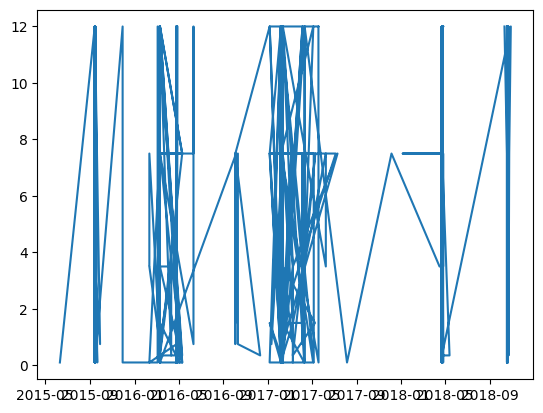

In [20]:
plt.plot(data["Sample Date"],data["Nitrate"])

## Prepping data for LSTM pytorch model

In [22]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Sample Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Nitrate(t-{i})'] = df['Nitrate'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Nitrate,Nitrate(t-1),Nitrate(t-2),Nitrate(t-3),Nitrate(t-4),Nitrate(t-5),Nitrate(t-6),Nitrate(t-7)
Sample Date,,,,,,,,
2015-09-14 09:20:00,0.10,3.5,7.5,7.50,7.50,12.00,12.00,0.10
2015-09-14 08:35:00,7.50,0.1,3.5,7.50,7.50,7.50,12.00,12.00
2015-09-14 00:00:00,12.00,7.5,0.1,3.50,7.50,7.50,7.50,12.00
2015-09-14 09:32:00,7.50,12.0,7.5,0.10,3.50,7.50,7.50,7.50
2015-09-14 11:36:00,0.35,7.5,12.0,7.50,0.10,3.50,7.50,7.50
...,...,...,...,...,...,...,...,...
2018-10-18 11:00:00,12.00,7.5,7.5,0.35,0.35,7.50,3.50,7.50
2018-10-18 10:30:00,0.10,12.0,7.5,7.50,0.35,0.35,7.50,3.50
2018-10-18 10:00:00,7.50,0.1,12.0,7.50,7.50,0.35,0.35,7.50


In [23]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 0.1 ,  3.5 ,  7.5 , ..., 12.  , 12.  ,  0.1 ],
       [ 7.5 ,  0.1 ,  3.5 , ...,  7.5 , 12.  , 12.  ],
       [12.  ,  7.5 ,  0.1 , ...,  7.5 ,  7.5 , 12.  ],
       ...,
       [ 7.5 ,  0.1 , 12.  , ...,  0.35,  0.35,  7.5 ],
       [ 7.5 ,  7.5 ,  0.1 , ...,  7.5 ,  0.35,  0.35],
       [12.  ,  7.5 ,  7.5 , ...,  7.5 ,  7.5 ,  0.35]])

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -0.42857143,  0.24369748, ...,  1.        ,
         1.        , -1.        ],
       [ 0.24369748, -1.        , -0.42857143, ...,  0.24369748,
         1.        ,  1.        ],
       [ 1.        ,  0.24369748, -1.        , ...,  0.24369748,
         0.24369748,  1.        ],
       ...,
       [ 0.24369748, -1.        ,  1.        , ..., -0.95798319,
        -0.95798319,  0.24369748],
       [ 0.24369748,  0.24369748, -1.        , ...,  0.24369748,
        -0.95798319, -0.95798319],
       [ 1.        ,  0.24369748,  0.24369748, ...,  0.24369748,
         0.24369748, -0.95798319]])

In [25]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2354, 7), (2354,))

In [26]:
X = dc(np.flip(X, axis=1))
X

array([[-1.        ,  1.        ,  1.        , ...,  0.24369748,
         0.24369748, -0.42857143],
       [ 1.        ,  1.        ,  0.24369748, ...,  0.24369748,
        -0.42857143, -1.        ],
       [ 1.        ,  0.24369748,  0.24369748, ..., -0.42857143,
        -1.        ,  0.24369748],
       ...,
       [ 0.24369748, -0.95798319, -0.95798319, ...,  0.24369748,
         1.        , -1.        ],
       [-0.95798319, -0.95798319,  0.24369748, ...,  1.        ,
        -1.        ,  0.24369748],
       [-0.95798319,  0.24369748,  0.24369748, ..., -1.        ,
         0.24369748,  0.24369748]])

In [28]:
# 5% test data and 95% train data

split_index = int(len(X) * 0.95)

split_index

2236

In [29]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 7), (118, 7), (2236,), (118,))

In [30]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 7, 1), (118, 7, 1), (2236, 1), (118, 1))

In [31]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2236, 7, 1]),
 torch.Size([118, 7, 1]),
 torch.Size([2236, 1]),
 torch.Size([118, 1]))

In [32]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [33]:
train_dataset

In [34]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [39]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [40]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

# Pytorch LSTM model

In [42]:
learning_rate = 0.001
num_epochs = 10000
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.431

Val Loss: 0.467
***************************************************

Epoch: 2
Batch 100, Loss: 0.435

Val Loss: 0.466
***************************************************

Epoch: 3
Batch 100, Loss: 0.427

Val Loss: 0.467
***************************************************

Epoch: 4
Batch 100, Loss: 0.434

Val Loss: 0.467
***************************************************

Epoch: 5
Batch 100, Loss: 0.435

Val Loss: 0.468
***************************************************

Epoch: 6
Batch 100, Loss: 0.436

Val Loss: 0.468
***************************************************

Epoch: 7
Batch 100, Loss: 0.426

Val Loss: 0.469
***************************************************

Epoch: 8
Batch 100, Loss: 0.438

Val Loss: 0.469
***************************************************

Epoch: 9
Batch 100, Loss: 0.426

Val Loss: 0.469
***************************************************

Epoch: 10
Batch 100, Loss: 0.434

Val Loss: 0.469
********************************

Batch 100, Loss: 0.440

Val Loss: 0.471
***************************************************

Epoch: 83
Batch 100, Loss: 0.442

Val Loss: 0.471
***************************************************

Epoch: 84
Batch 100, Loss: 0.436

Val Loss: 0.472
***************************************************

Epoch: 85
Batch 100, Loss: 0.432

Val Loss: 0.471
***************************************************

Epoch: 86
Batch 100, Loss: 0.437

Val Loss: 0.472
***************************************************

Epoch: 87
Batch 100, Loss: 0.427

Val Loss: 0.471
***************************************************

Epoch: 88
Batch 100, Loss: 0.436

Val Loss: 0.470
***************************************************

Epoch: 89
Batch 100, Loss: 0.429

Val Loss: 0.470
***************************************************

Epoch: 90
Batch 100, Loss: 0.434

Val Loss: 0.472
***************************************************

Epoch: 91
Batch 100, Loss: 0.436

Val Loss: 0.472
*********************************

Batch 100, Loss: 0.426

Val Loss: 0.471
***************************************************

Epoch: 163
Batch 100, Loss: 0.424

Val Loss: 0.472
***************************************************

Epoch: 164
Batch 100, Loss: 0.428

Val Loss: 0.471
***************************************************

Epoch: 165
Batch 100, Loss: 0.433

Val Loss: 0.473
***************************************************

Epoch: 166
Batch 100, Loss: 0.422

Val Loss: 0.472
***************************************************

Epoch: 167
Batch 100, Loss: 0.425

Val Loss: 0.471
***************************************************

Epoch: 168
Batch 100, Loss: 0.430

Val Loss: 0.471
***************************************************

Epoch: 169
Batch 100, Loss: 0.439

Val Loss: 0.472
***************************************************

Epoch: 170
Batch 100, Loss: 0.431

Val Loss: 0.472
***************************************************

Epoch: 171
Batch 100, Loss: 0.426

Val Loss: 0.471
************************

Batch 100, Loss: 0.432

Val Loss: 0.472
***************************************************

Epoch: 243
Batch 100, Loss: 0.431

Val Loss: 0.471
***************************************************

Epoch: 244
Batch 100, Loss: 0.422

Val Loss: 0.471
***************************************************

Epoch: 245
Batch 100, Loss: 0.435

Val Loss: 0.472
***************************************************

Epoch: 246
Batch 100, Loss: 0.430

Val Loss: 0.471
***************************************************

Epoch: 247
Batch 100, Loss: 0.438

Val Loss: 0.472
***************************************************

Epoch: 248
Batch 100, Loss: 0.430

Val Loss: 0.472
***************************************************

Epoch: 249
Batch 100, Loss: 0.437

Val Loss: 0.473
***************************************************

Epoch: 250
Batch 100, Loss: 0.414

Val Loss: 0.472
***************************************************

Epoch: 251
Batch 100, Loss: 0.432

Val Loss: 0.472
************************

Batch 100, Loss: 0.427

Val Loss: 0.473
***************************************************

Epoch: 323
Batch 100, Loss: 0.421

Val Loss: 0.472
***************************************************

Epoch: 324
Batch 100, Loss: 0.429

Val Loss: 0.472
***************************************************

Epoch: 325
Batch 100, Loss: 0.439

Val Loss: 0.473
***************************************************

Epoch: 326
Batch 100, Loss: 0.427

Val Loss: 0.472
***************************************************

Epoch: 327
Batch 100, Loss: 0.431

Val Loss: 0.474
***************************************************

Epoch: 328
Batch 100, Loss: 0.431

Val Loss: 0.472
***************************************************

Epoch: 329
Batch 100, Loss: 0.423

Val Loss: 0.473
***************************************************

Epoch: 330
Batch 100, Loss: 0.436

Val Loss: 0.472
***************************************************

Epoch: 331
Batch 100, Loss: 0.424

Val Loss: 0.472
************************

Batch 100, Loss: 0.428

Val Loss: 0.473
***************************************************

Epoch: 403
Batch 100, Loss: 0.430

Val Loss: 0.474
***************************************************

Epoch: 404
Batch 100, Loss: 0.432

Val Loss: 0.473
***************************************************

Epoch: 405
Batch 100, Loss: 0.431

Val Loss: 0.474
***************************************************

Epoch: 406
Batch 100, Loss: 0.428

Val Loss: 0.473
***************************************************

Epoch: 407
Batch 100, Loss: 0.428

Val Loss: 0.473
***************************************************

Epoch: 408
Batch 100, Loss: 0.425

Val Loss: 0.473
***************************************************

Epoch: 409
Batch 100, Loss: 0.441

Val Loss: 0.474
***************************************************

Epoch: 410
Batch 100, Loss: 0.428

Val Loss: 0.474
***************************************************

Epoch: 411
Batch 100, Loss: 0.419

Val Loss: 0.473
************************

Batch 100, Loss: 0.426

Val Loss: 0.474
***************************************************

Epoch: 483
Batch 100, Loss: 0.437

Val Loss: 0.476
***************************************************

Epoch: 484
Batch 100, Loss: 0.425

Val Loss: 0.475
***************************************************

Epoch: 485
Batch 100, Loss: 0.430

Val Loss: 0.475
***************************************************

Epoch: 486
Batch 100, Loss: 0.434

Val Loss: 0.476
***************************************************

Epoch: 487
Batch 100, Loss: 0.424

Val Loss: 0.476
***************************************************

Epoch: 488
Batch 100, Loss: 0.424

Val Loss: 0.476
***************************************************

Epoch: 489
Batch 100, Loss: 0.420

Val Loss: 0.475
***************************************************

Epoch: 490
Batch 100, Loss: 0.431

Val Loss: 0.476
***************************************************

Epoch: 491
Batch 100, Loss: 0.424

Val Loss: 0.475
************************

Batch 100, Loss: 0.435

Val Loss: 0.481
***************************************************

Epoch: 563
Batch 100, Loss: 0.430

Val Loss: 0.481
***************************************************

Epoch: 564
Batch 100, Loss: 0.431

Val Loss: 0.481
***************************************************

Epoch: 565
Batch 100, Loss: 0.431

Val Loss: 0.482
***************************************************

Epoch: 566
Batch 100, Loss: 0.424

Val Loss: 0.483
***************************************************

Epoch: 567
Batch 100, Loss: 0.429

Val Loss: 0.481
***************************************************

Epoch: 568
Batch 100, Loss: 0.433

Val Loss: 0.481
***************************************************

Epoch: 569
Batch 100, Loss: 0.436

Val Loss: 0.481
***************************************************

Epoch: 570
Batch 100, Loss: 0.419

Val Loss: 0.484
***************************************************

Epoch: 571
Batch 100, Loss: 0.438

Val Loss: 0.483
************************

Batch 100, Loss: 0.436

Val Loss: 0.488
***************************************************

Epoch: 643
Batch 100, Loss: 0.426

Val Loss: 0.490
***************************************************

Epoch: 644
Batch 100, Loss: 0.435

Val Loss: 0.489
***************************************************

Epoch: 645
Batch 100, Loss: 0.427

Val Loss: 0.487
***************************************************

Epoch: 646
Batch 100, Loss: 0.427

Val Loss: 0.487
***************************************************

Epoch: 647
Batch 100, Loss: 0.426

Val Loss: 0.489
***************************************************

Epoch: 648
Batch 100, Loss: 0.428

Val Loss: 0.489
***************************************************

Epoch: 649
Batch 100, Loss: 0.420

Val Loss: 0.490
***************************************************

Epoch: 650
Batch 100, Loss: 0.420

Val Loss: 0.490
***************************************************

Epoch: 651
Batch 100, Loss: 0.427

Val Loss: 0.489
************************

Batch 100, Loss: 0.419

Val Loss: 0.490
***************************************************

Epoch: 722
Batch 100, Loss: 0.419

Val Loss: 0.489
***************************************************

Epoch: 723
Batch 100, Loss: 0.421

Val Loss: 0.493
***************************************************

Epoch: 724
Batch 100, Loss: 0.434

Val Loss: 0.498
***************************************************

Epoch: 725
Batch 100, Loss: 0.426

Val Loss: 0.491
***************************************************

Epoch: 726
Batch 100, Loss: 0.421

Val Loss: 0.495
***************************************************

Epoch: 727
Batch 100, Loss: 0.433

Val Loss: 0.494
***************************************************

Epoch: 728
Batch 100, Loss: 0.421

Val Loss: 0.489
***************************************************

Epoch: 729
Batch 100, Loss: 0.420

Val Loss: 0.493
***************************************************

Epoch: 730
Batch 100, Loss: 0.421

Val Loss: 0.490
************************

Batch 100, Loss: 0.422

Val Loss: 0.494
***************************************************

Epoch: 802
Batch 100, Loss: 0.427

Val Loss: 0.491
***************************************************

Epoch: 803
Batch 100, Loss: 0.416

Val Loss: 0.495
***************************************************

Epoch: 804
Batch 100, Loss: 0.428

Val Loss: 0.493
***************************************************

Epoch: 805
Batch 100, Loss: 0.422

Val Loss: 0.490
***************************************************

Epoch: 806
Batch 100, Loss: 0.420

Val Loss: 0.495
***************************************************

Epoch: 807
Batch 100, Loss: 0.420

Val Loss: 0.492
***************************************************

Epoch: 808
Batch 100, Loss: 0.417

Val Loss: 0.492
***************************************************

Epoch: 809
Batch 100, Loss: 0.411

Val Loss: 0.489
***************************************************

Epoch: 810
Batch 100, Loss: 0.416

Val Loss: 0.488
************************

Batch 100, Loss: 0.423

Val Loss: 0.484
***************************************************

Epoch: 882
Batch 100, Loss: 0.421

Val Loss: 0.488
***************************************************

Epoch: 883
Batch 100, Loss: 0.422

Val Loss: 0.484
***************************************************

Epoch: 884
Batch 100, Loss: 0.423

Val Loss: 0.484
***************************************************

Epoch: 885
Batch 100, Loss: 0.416

Val Loss: 0.484
***************************************************

Epoch: 886
Batch 100, Loss: 0.419

Val Loss: 0.483
***************************************************

Epoch: 887
Batch 100, Loss: 0.429

Val Loss: 0.483
***************************************************

Epoch: 888
Batch 100, Loss: 0.414

Val Loss: 0.484
***************************************************

Epoch: 889
Batch 100, Loss: 0.412

Val Loss: 0.484
***************************************************

Epoch: 890
Batch 100, Loss: 0.413

Val Loss: 0.484
************************

Batch 100, Loss: 0.414

Val Loss: 0.480
***************************************************

Epoch: 961
Batch 100, Loss: 0.409

Val Loss: 0.477
***************************************************

Epoch: 962
Batch 100, Loss: 0.420

Val Loss: 0.482
***************************************************

Epoch: 963
Batch 100, Loss: 0.423

Val Loss: 0.480
***************************************************

Epoch: 964
Batch 100, Loss: 0.425

Val Loss: 0.480
***************************************************

Epoch: 965
Batch 100, Loss: 0.419

Val Loss: 0.481
***************************************************

Epoch: 966
Batch 100, Loss: 0.415

Val Loss: 0.480
***************************************************

Epoch: 967
Batch 100, Loss: 0.420

Val Loss: 0.479
***************************************************

Epoch: 968
Batch 100, Loss: 0.420

Val Loss: 0.479
***************************************************

Epoch: 969
Batch 100, Loss: 0.418

Val Loss: 0.480
************************

Batch 100, Loss: 0.419

Val Loss: 0.480
***************************************************

Epoch: 1041
Batch 100, Loss: 0.408

Val Loss: 0.479
***************************************************

Epoch: 1042
Batch 100, Loss: 0.420

Val Loss: 0.482
***************************************************

Epoch: 1043
Batch 100, Loss: 0.425

Val Loss: 0.481
***************************************************

Epoch: 1044
Batch 100, Loss: 0.412

Val Loss: 0.478
***************************************************

Epoch: 1045
Batch 100, Loss: 0.414

Val Loss: 0.479
***************************************************

Epoch: 1046
Batch 100, Loss: 0.420

Val Loss: 0.480
***************************************************

Epoch: 1047
Batch 100, Loss: 0.417

Val Loss: 0.479
***************************************************

Epoch: 1048
Batch 100, Loss: 0.419

Val Loss: 0.482
***************************************************

Epoch: 1049
Batch 100, Loss: 0.430

Val Loss: 0.480
***************

Batch 100, Loss: 0.416

Val Loss: 0.484
***************************************************

Epoch: 1121
Batch 100, Loss: 0.411

Val Loss: 0.484
***************************************************

Epoch: 1122
Batch 100, Loss: 0.405

Val Loss: 0.485
***************************************************

Epoch: 1123
Batch 100, Loss: 0.409

Val Loss: 0.486
***************************************************

Epoch: 1124
Batch 100, Loss: 0.415

Val Loss: 0.486
***************************************************

Epoch: 1125
Batch 100, Loss: 0.404

Val Loss: 0.486
***************************************************

Epoch: 1126
Batch 100, Loss: 0.414

Val Loss: 0.488
***************************************************

Epoch: 1127
Batch 100, Loss: 0.420

Val Loss: 0.487
***************************************************

Epoch: 1128
Batch 100, Loss: 0.418

Val Loss: 0.485
***************************************************

Epoch: 1129
Batch 100, Loss: 0.413

Val Loss: 0.487
***************

Batch 100, Loss: 0.406

Val Loss: 0.489
***************************************************

Epoch: 1201
Batch 100, Loss: 0.402

Val Loss: 0.489
***************************************************

Epoch: 1202
Batch 100, Loss: 0.400

Val Loss: 0.491
***************************************************

Epoch: 1203
Batch 100, Loss: 0.413

Val Loss: 0.489
***************************************************

Epoch: 1204
Batch 100, Loss: 0.404

Val Loss: 0.491
***************************************************

Epoch: 1205
Batch 100, Loss: 0.420

Val Loss: 0.491
***************************************************

Epoch: 1206
Batch 100, Loss: 0.422

Val Loss: 0.491
***************************************************

Epoch: 1207
Batch 100, Loss: 0.399

Val Loss: 0.491
***************************************************

Epoch: 1208
Batch 100, Loss: 0.406

Val Loss: 0.487
***************************************************

Epoch: 1209
Batch 100, Loss: 0.406

Val Loss: 0.488
***************

Batch 100, Loss: 0.415

Val Loss: 0.494
***************************************************

Epoch: 1281
Batch 100, Loss: 0.413

Val Loss: 0.492
***************************************************

Epoch: 1282
Batch 100, Loss: 0.409

Val Loss: 0.492
***************************************************

Epoch: 1283
Batch 100, Loss: 0.413

Val Loss: 0.496
***************************************************

Epoch: 1284
Batch 100, Loss: 0.411

Val Loss: 0.492
***************************************************

Epoch: 1285
Batch 100, Loss: 0.417

Val Loss: 0.492
***************************************************

Epoch: 1286
Batch 100, Loss: 0.412

Val Loss: 0.495
***************************************************

Epoch: 1287
Batch 100, Loss: 0.407

Val Loss: 0.493
***************************************************

Epoch: 1288
Batch 100, Loss: 0.418

Val Loss: 0.493
***************************************************

Epoch: 1289
Batch 100, Loss: 0.399

Val Loss: 0.492
***************

Batch 100, Loss: 0.406

Val Loss: 0.493
***************************************************

Epoch: 1361
Batch 100, Loss: 0.412

Val Loss: 0.492
***************************************************

Epoch: 1362
Batch 100, Loss: 0.401

Val Loss: 0.490
***************************************************

Epoch: 1363
Batch 100, Loss: 0.408

Val Loss: 0.492
***************************************************

Epoch: 1364
Batch 100, Loss: 0.407

Val Loss: 0.495
***************************************************

Epoch: 1365
Batch 100, Loss: 0.404

Val Loss: 0.491
***************************************************

Epoch: 1366
Batch 100, Loss: 0.405

Val Loss: 0.492
***************************************************

Epoch: 1367
Batch 100, Loss: 0.406

Val Loss: 0.492
***************************************************

Epoch: 1368
Batch 100, Loss: 0.397

Val Loss: 0.492
***************************************************

Epoch: 1369
Batch 100, Loss: 0.396

Val Loss: 0.491
***************

Batch 100, Loss: 0.399

Val Loss: 0.492
***************************************************

Epoch: 1441
Batch 100, Loss: 0.391

Val Loss: 0.490
***************************************************

Epoch: 1442
Batch 100, Loss: 0.411

Val Loss: 0.496
***************************************************

Epoch: 1443
Batch 100, Loss: 0.403

Val Loss: 0.492
***************************************************

Epoch: 1444
Batch 100, Loss: 0.404

Val Loss: 0.492
***************************************************

Epoch: 1445
Batch 100, Loss: 0.400

Val Loss: 0.492
***************************************************

Epoch: 1446
Batch 100, Loss: 0.397

Val Loss: 0.491
***************************************************

Epoch: 1447
Batch 100, Loss: 0.406

Val Loss: 0.493
***************************************************

Epoch: 1448
Batch 100, Loss: 0.401

Val Loss: 0.493
***************************************************

Epoch: 1449
Batch 100, Loss: 0.395

Val Loss: 0.494
***************

Batch 100, Loss: 0.401

Val Loss: 0.490
***************************************************

Epoch: 1521
Batch 100, Loss: 0.406

Val Loss: 0.494
***************************************************

Epoch: 1522
Batch 100, Loss: 0.413

Val Loss: 0.494
***************************************************

Epoch: 1523
Batch 100, Loss: 0.395

Val Loss: 0.491
***************************************************

Epoch: 1524
Batch 100, Loss: 0.397

Val Loss: 0.491
***************************************************

Epoch: 1525
Batch 100, Loss: 0.410

Val Loss: 0.493
***************************************************

Epoch: 1526
Batch 100, Loss: 0.407

Val Loss: 0.494
***************************************************

Epoch: 1527
Batch 100, Loss: 0.414

Val Loss: 0.491
***************************************************

Epoch: 1528
Batch 100, Loss: 0.407

Val Loss: 0.496
***************************************************

Epoch: 1529
Batch 100, Loss: 0.410

Val Loss: 0.495
***************

Batch 100, Loss: 0.401

Val Loss: 0.490
***************************************************

Epoch: 1601
Batch 100, Loss: 0.399

Val Loss: 0.490
***************************************************

Epoch: 1602
Batch 100, Loss: 0.408

Val Loss: 0.492
***************************************************

Epoch: 1603
Batch 100, Loss: 0.396

Val Loss: 0.489
***************************************************

Epoch: 1604
Batch 100, Loss: 0.400

Val Loss: 0.492
***************************************************

Epoch: 1605
Batch 100, Loss: 0.407

Val Loss: 0.490
***************************************************

Epoch: 1606
Batch 100, Loss: 0.411

Val Loss: 0.492
***************************************************

Epoch: 1607
Batch 100, Loss: 0.400

Val Loss: 0.490
***************************************************

Epoch: 1608
Batch 100, Loss: 0.399

Val Loss: 0.491
***************************************************

Epoch: 1609
Batch 100, Loss: 0.394

Val Loss: 0.490
***************

Batch 100, Loss: 0.414

Val Loss: 0.493
***************************************************

Epoch: 1681
Batch 100, Loss: 0.395

Val Loss: 0.490
***************************************************

Epoch: 1682
Batch 100, Loss: 0.406

Val Loss: 0.491
***************************************************

Epoch: 1683
Batch 100, Loss: 0.399

Val Loss: 0.490
***************************************************

Epoch: 1684
Batch 100, Loss: 0.391

Val Loss: 0.491
***************************************************

Epoch: 1685
Batch 100, Loss: 0.411

Val Loss: 0.493
***************************************************

Epoch: 1686
Batch 100, Loss: 0.400

Val Loss: 0.491
***************************************************

Epoch: 1687
Batch 100, Loss: 0.402

Val Loss: 0.492
***************************************************

Epoch: 1688
Batch 100, Loss: 0.405

Val Loss: 0.492
***************************************************

Epoch: 1689
Batch 100, Loss: 0.398

Val Loss: 0.493
***************

Batch 100, Loss: 0.389

Val Loss: 0.489
***************************************************

Epoch: 1760
Batch 100, Loss: 0.396

Val Loss: 0.491
***************************************************

Epoch: 1761
Batch 100, Loss: 0.396

Val Loss: 0.491
***************************************************

Epoch: 1762
Batch 100, Loss: 0.398

Val Loss: 0.490
***************************************************

Epoch: 1763
Batch 100, Loss: 0.409

Val Loss: 0.489
***************************************************

Epoch: 1764
Batch 100, Loss: 0.408

Val Loss: 0.491
***************************************************

Epoch: 1765
Batch 100, Loss: 0.406

Val Loss: 0.491
***************************************************

Epoch: 1766
Batch 100, Loss: 0.406

Val Loss: 0.493
***************************************************

Epoch: 1767
Batch 100, Loss: 0.399

Val Loss: 0.489
***************************************************

Epoch: 1768
Batch 100, Loss: 0.403

Val Loss: 0.489
***************


Val Loss: 0.490
***************************************************

Epoch: 1839
Batch 100, Loss: 0.403

Val Loss: 0.487
***************************************************

Epoch: 1840
Batch 100, Loss: 0.402

Val Loss: 0.490
***************************************************

Epoch: 1841
Batch 100, Loss: 0.403

Val Loss: 0.492
***************************************************

Epoch: 1842
Batch 100, Loss: 0.414

Val Loss: 0.490
***************************************************

Epoch: 1843
Batch 100, Loss: 0.398

Val Loss: 0.488
***************************************************

Epoch: 1844
Batch 100, Loss: 0.409

Val Loss: 0.488
***************************************************

Epoch: 1845
Batch 100, Loss: 0.408

Val Loss: 0.488
***************************************************

Epoch: 1846
Batch 100, Loss: 0.402

Val Loss: 0.490
***************************************************

Epoch: 1847
Batch 100, Loss: 0.406

Val Loss: 0.491
**************************************

Batch 100, Loss: 0.397

Val Loss: 0.487
***************************************************

Epoch: 1919
Batch 100, Loss: 0.400

Val Loss: 0.486
***************************************************

Epoch: 1920
Batch 100, Loss: 0.399

Val Loss: 0.487
***************************************************

Epoch: 1921
Batch 100, Loss: 0.394

Val Loss: 0.486
***************************************************

Epoch: 1922
Batch 100, Loss: 0.411

Val Loss: 0.486
***************************************************

Epoch: 1923
Batch 100, Loss: 0.403

Val Loss: 0.489
***************************************************

Epoch: 1924
Batch 100, Loss: 0.397

Val Loss: 0.486
***************************************************

Epoch: 1925
Batch 100, Loss: 0.397

Val Loss: 0.489
***************************************************

Epoch: 1926
Batch 100, Loss: 0.408

Val Loss: 0.489
***************************************************

Epoch: 1927
Batch 100, Loss: 0.397

Val Loss: 0.488
***************

Batch 100, Loss: 0.397

Val Loss: 0.486
***************************************************

Epoch: 1999
Batch 100, Loss: 0.401

Val Loss: 0.486
***************************************************

Epoch: 2000
Batch 100, Loss: 0.401

Val Loss: 0.486
***************************************************

Epoch: 2001
Batch 100, Loss: 0.392

Val Loss: 0.488
***************************************************

Epoch: 2002
Batch 100, Loss: 0.409

Val Loss: 0.487
***************************************************

Epoch: 2003
Batch 100, Loss: 0.408

Val Loss: 0.491
***************************************************

Epoch: 2004
Batch 100, Loss: 0.395

Val Loss: 0.488
***************************************************

Epoch: 2005
Batch 100, Loss: 0.402

Val Loss: 0.486
***************************************************

Epoch: 2006
Batch 100, Loss: 0.401

Val Loss: 0.485
***************************************************

Epoch: 2007
Batch 100, Loss: 0.412

Val Loss: 0.488
***************

Batch 100, Loss: 0.390

Val Loss: 0.484
***************************************************

Epoch: 2079
Batch 100, Loss: 0.398

Val Loss: 0.484
***************************************************

Epoch: 2080
Batch 100, Loss: 0.401

Val Loss: 0.485
***************************************************

Epoch: 2081
Batch 100, Loss: 0.408

Val Loss: 0.485
***************************************************

Epoch: 2082
Batch 100, Loss: 0.399

Val Loss: 0.487
***************************************************

Epoch: 2083
Batch 100, Loss: 0.389

Val Loss: 0.485
***************************************************

Epoch: 2084
Batch 100, Loss: 0.412

Val Loss: 0.483
***************************************************

Epoch: 2085
Batch 100, Loss: 0.404

Val Loss: 0.484
***************************************************

Epoch: 2086
Batch 100, Loss: 0.404

Val Loss: 0.487
***************************************************

Epoch: 2087
Batch 100, Loss: 0.390

Val Loss: 0.483
***************

Batch 100, Loss: 0.395

Val Loss: 0.485
***************************************************

Epoch: 2159
Batch 100, Loss: 0.400

Val Loss: 0.482
***************************************************

Epoch: 2160
Batch 100, Loss: 0.398

Val Loss: 0.485
***************************************************

Epoch: 2161
Batch 100, Loss: 0.408

Val Loss: 0.485
***************************************************

Epoch: 2162
Batch 100, Loss: 0.397

Val Loss: 0.483
***************************************************

Epoch: 2163
Batch 100, Loss: 0.398

Val Loss: 0.484
***************************************************

Epoch: 2164
Batch 100, Loss: 0.403

Val Loss: 0.484
***************************************************

Epoch: 2165
Batch 100, Loss: 0.404

Val Loss: 0.485
***************************************************

Epoch: 2166
Batch 100, Loss: 0.398

Val Loss: 0.485
***************************************************

Epoch: 2167
Batch 100, Loss: 0.399

Val Loss: 0.486
***************

Batch 100, Loss: 0.416

Val Loss: 0.484
***************************************************

Epoch: 2239
Batch 100, Loss: 0.401

Val Loss: 0.482
***************************************************

Epoch: 2240
Batch 100, Loss: 0.399

Val Loss: 0.483
***************************************************

Epoch: 2241
Batch 100, Loss: 0.400

Val Loss: 0.483
***************************************************

Epoch: 2242
Batch 100, Loss: 0.388

Val Loss: 0.483
***************************************************

Epoch: 2243
Batch 100, Loss: 0.383

Val Loss: 0.481
***************************************************

Epoch: 2244
Batch 100, Loss: 0.406

Val Loss: 0.485
***************************************************

Epoch: 2245
Batch 100, Loss: 0.409

Val Loss: 0.487
***************************************************

Epoch: 2246
Batch 100, Loss: 0.399

Val Loss: 0.485
***************************************************

Epoch: 2247
Batch 100, Loss: 0.400

Val Loss: 0.485
***************

Batch 100, Loss: 0.394

Val Loss: 0.484
***************************************************

Epoch: 2319
Batch 100, Loss: 0.409

Val Loss: 0.483
***************************************************

Epoch: 2320
Batch 100, Loss: 0.408

Val Loss: 0.483
***************************************************

Epoch: 2321
Batch 100, Loss: 0.407

Val Loss: 0.484
***************************************************

Epoch: 2322
Batch 100, Loss: 0.407

Val Loss: 0.482
***************************************************

Epoch: 2323
Batch 100, Loss: 0.400

Val Loss: 0.483
***************************************************

Epoch: 2324
Batch 100, Loss: 0.404

Val Loss: 0.484
***************************************************

Epoch: 2325
Batch 100, Loss: 0.408

Val Loss: 0.485
***************************************************

Epoch: 2326
Batch 100, Loss: 0.404

Val Loss: 0.481
***************************************************

Epoch: 2327
Batch 100, Loss: 0.400

Val Loss: 0.483
***************

Batch 100, Loss: 0.397

Val Loss: 0.483
***************************************************

Epoch: 2399
Batch 100, Loss: 0.414

Val Loss: 0.483
***************************************************

Epoch: 2400
Batch 100, Loss: 0.401

Val Loss: 0.485
***************************************************

Epoch: 2401
Batch 100, Loss: 0.404

Val Loss: 0.481
***************************************************

Epoch: 2402
Batch 100, Loss: 0.408

Val Loss: 0.483
***************************************************

Epoch: 2403
Batch 100, Loss: 0.396

Val Loss: 0.484
***************************************************

Epoch: 2404
Batch 100, Loss: 0.403

Val Loss: 0.482
***************************************************

Epoch: 2405
Batch 100, Loss: 0.392

Val Loss: 0.481
***************************************************

Epoch: 2406
Batch 100, Loss: 0.394

Val Loss: 0.481
***************************************************

Epoch: 2407
Batch 100, Loss: 0.394

Val Loss: 0.482
***************

Batch 100, Loss: 0.395

Val Loss: 0.482
***************************************************

Epoch: 2479
Batch 100, Loss: 0.404

Val Loss: 0.483
***************************************************

Epoch: 2480
Batch 100, Loss: 0.391

Val Loss: 0.480
***************************************************

Epoch: 2481
Batch 100, Loss: 0.396

Val Loss: 0.483
***************************************************

Epoch: 2482
Batch 100, Loss: 0.407

Val Loss: 0.484
***************************************************

Epoch: 2483
Batch 100, Loss: 0.393

Val Loss: 0.481
***************************************************

Epoch: 2484
Batch 100, Loss: 0.397

Val Loss: 0.483
***************************************************

Epoch: 2485
Batch 100, Loss: 0.407

Val Loss: 0.481
***************************************************

Epoch: 2486
Batch 100, Loss: 0.400

Val Loss: 0.482
***************************************************

Epoch: 2487
Batch 100, Loss: 0.402

Val Loss: 0.485
***************

Batch 100, Loss: 0.396

Val Loss: 0.481
***************************************************

Epoch: 2559
Batch 100, Loss: 0.389

Val Loss: 0.483
***************************************************

Epoch: 2560
Batch 100, Loss: 0.401

Val Loss: 0.483
***************************************************

Epoch: 2561
Batch 100, Loss: 0.407

Val Loss: 0.482
***************************************************

Epoch: 2562
Batch 100, Loss: 0.399

Val Loss: 0.482
***************************************************

Epoch: 2563
Batch 100, Loss: 0.400

Val Loss: 0.483
***************************************************

Epoch: 2564
Batch 100, Loss: 0.402

Val Loss: 0.484
***************************************************

Epoch: 2565
Batch 100, Loss: 0.396

Val Loss: 0.482
***************************************************

Epoch: 2566
Batch 100, Loss: 0.395

Val Loss: 0.483
***************************************************

Epoch: 2567
Batch 100, Loss: 0.391

Val Loss: 0.481
***************

Batch 100, Loss: 0.403

Val Loss: 0.481
***************************************************

Epoch: 2639
Batch 100, Loss: 0.406

Val Loss: 0.481
***************************************************

Epoch: 2640
Batch 100, Loss: 0.405

Val Loss: 0.484
***************************************************

Epoch: 2641
Batch 100, Loss: 0.407

Val Loss: 0.483
***************************************************

Epoch: 2642
Batch 100, Loss: 0.403

Val Loss: 0.481
***************************************************

Epoch: 2643
Batch 100, Loss: 0.401

Val Loss: 0.483
***************************************************

Epoch: 2644
Batch 100, Loss: 0.399

Val Loss: 0.480
***************************************************

Epoch: 2645
Batch 100, Loss: 0.406

Val Loss: 0.484
***************************************************

Epoch: 2646
Batch 100, Loss: 0.397

Val Loss: 0.481
***************************************************

Epoch: 2647
Batch 100, Loss: 0.404

Val Loss: 0.482
***************

Batch 100, Loss: 0.403

Val Loss: 0.482
***************************************************

Epoch: 2719
Batch 100, Loss: 0.390

Val Loss: 0.481
***************************************************

Epoch: 2720
Batch 100, Loss: 0.402

Val Loss: 0.483
***************************************************

Epoch: 2721
Batch 100, Loss: 0.405

Val Loss: 0.481
***************************************************

Epoch: 2722
Batch 100, Loss: 0.411

Val Loss: 0.484
***************************************************

Epoch: 2723
Batch 100, Loss: 0.398

Val Loss: 0.482
***************************************************

Epoch: 2724
Batch 100, Loss: 0.395

Val Loss: 0.480
***************************************************

Epoch: 2725
Batch 100, Loss: 0.400

Val Loss: 0.481
***************************************************

Epoch: 2726
Batch 100, Loss: 0.398

Val Loss: 0.481
***************************************************

Epoch: 2727
Batch 100, Loss: 0.399

Val Loss: 0.481
***************

Batch 100, Loss: 0.405

Val Loss: 0.484
***************************************************

Epoch: 2799
Batch 100, Loss: 0.403

Val Loss: 0.483
***************************************************

Epoch: 2800
Batch 100, Loss: 0.401

Val Loss: 0.482
***************************************************

Epoch: 2801
Batch 100, Loss: 0.406

Val Loss: 0.480
***************************************************

Epoch: 2802
Batch 100, Loss: 0.392

Val Loss: 0.481
***************************************************

Epoch: 2803
Batch 100, Loss: 0.396

Val Loss: 0.483
***************************************************

Epoch: 2804
Batch 100, Loss: 0.400

Val Loss: 0.483
***************************************************

Epoch: 2805
Batch 100, Loss: 0.399

Val Loss: 0.481
***************************************************

Epoch: 2806
Batch 100, Loss: 0.395

Val Loss: 0.481
***************************************************

Epoch: 2807
Batch 100, Loss: 0.396

Val Loss: 0.484
***************

Batch 100, Loss: 0.389

Val Loss: 0.481
***************************************************

Epoch: 2879
Batch 100, Loss: 0.397

Val Loss: 0.481
***************************************************

Epoch: 2880
Batch 100, Loss: 0.404

Val Loss: 0.480
***************************************************

Epoch: 2881
Batch 100, Loss: 0.409

Val Loss: 0.483
***************************************************

Epoch: 2882
Batch 100, Loss: 0.407

Val Loss: 0.481
***************************************************

Epoch: 2883
Batch 100, Loss: 0.395

Val Loss: 0.480
***************************************************

Epoch: 2884
Batch 100, Loss: 0.411

Val Loss: 0.480
***************************************************

Epoch: 2885
Batch 100, Loss: 0.397

Val Loss: 0.483
***************************************************

Epoch: 2886
Batch 100, Loss: 0.401

Val Loss: 0.482
***************************************************

Epoch: 2887
Batch 100, Loss: 0.391

Val Loss: 0.482
***************

Batch 100, Loss: 0.410

Val Loss: 0.485
***************************************************

Epoch: 2959
Batch 100, Loss: 0.405

Val Loss: 0.481
***************************************************

Epoch: 2960
Batch 100, Loss: 0.396

Val Loss: 0.481
***************************************************

Epoch: 2961
Batch 100, Loss: 0.402

Val Loss: 0.480
***************************************************

Epoch: 2962
Batch 100, Loss: 0.401

Val Loss: 0.481
***************************************************

Epoch: 2963
Batch 100, Loss: 0.397

Val Loss: 0.483
***************************************************

Epoch: 2964
Batch 100, Loss: 0.401

Val Loss: 0.481
***************************************************

Epoch: 2965
Batch 100, Loss: 0.405

Val Loss: 0.483
***************************************************

Epoch: 2966
Batch 100, Loss: 0.399

Val Loss: 0.480
***************************************************

Epoch: 2967
Batch 100, Loss: 0.394

Val Loss: 0.480
***************

Batch 100, Loss: 0.402

Val Loss: 0.484
***************************************************

Epoch: 3039
Batch 100, Loss: 0.400

Val Loss: 0.485
***************************************************

Epoch: 3040
Batch 100, Loss: 0.401

Val Loss: 0.482
***************************************************

Epoch: 3041
Batch 100, Loss: 0.402

Val Loss: 0.484
***************************************************

Epoch: 3042
Batch 100, Loss: 0.402

Val Loss: 0.484
***************************************************

Epoch: 3043
Batch 100, Loss: 0.396

Val Loss: 0.482
***************************************************

Epoch: 3044
Batch 100, Loss: 0.410

Val Loss: 0.481
***************************************************

Epoch: 3045
Batch 100, Loss: 0.399

Val Loss: 0.482
***************************************************

Epoch: 3046
Batch 100, Loss: 0.408

Val Loss: 0.483
***************************************************

Epoch: 3047
Batch 100, Loss: 0.399

Val Loss: 0.482
***************

Batch 100, Loss: 0.405

Val Loss: 0.481
***************************************************

Epoch: 3119
Batch 100, Loss: 0.398

Val Loss: 0.481
***************************************************

Epoch: 3120
Batch 100, Loss: 0.398

Val Loss: 0.482
***************************************************

Epoch: 3121
Batch 100, Loss: 0.397

Val Loss: 0.482
***************************************************

Epoch: 3122
Batch 100, Loss: 0.402

Val Loss: 0.482
***************************************************

Epoch: 3123
Batch 100, Loss: 0.404

Val Loss: 0.482
***************************************************

Epoch: 3124
Batch 100, Loss: 0.398

Val Loss: 0.483
***************************************************

Epoch: 3125
Batch 100, Loss: 0.399

Val Loss: 0.483
***************************************************

Epoch: 3126
Batch 100, Loss: 0.398

Val Loss: 0.482
***************************************************

Epoch: 3127
Batch 100, Loss: 0.402

Val Loss: 0.482
***************

Batch 100, Loss: 0.403

Val Loss: 0.485
***************************************************

Epoch: 3199
Batch 100, Loss: 0.408

Val Loss: 0.483
***************************************************

Epoch: 3200
Batch 100, Loss: 0.408

Val Loss: 0.483
***************************************************

Epoch: 3201
Batch 100, Loss: 0.402

Val Loss: 0.483
***************************************************

Epoch: 3202
Batch 100, Loss: 0.391

Val Loss: 0.481
***************************************************

Epoch: 3203
Batch 100, Loss: 0.401

Val Loss: 0.483
***************************************************

Epoch: 3204
Batch 100, Loss: 0.405

Val Loss: 0.482
***************************************************

Epoch: 3205
Batch 100, Loss: 0.402

Val Loss: 0.483
***************************************************

Epoch: 3206
Batch 100, Loss: 0.397

Val Loss: 0.485
***************************************************

Epoch: 3207
Batch 100, Loss: 0.396

Val Loss: 0.480
***************

Batch 100, Loss: 0.402

Val Loss: 0.486
***************************************************

Epoch: 3279
Batch 100, Loss: 0.406

Val Loss: 0.485
***************************************************

Epoch: 3280
Batch 100, Loss: 0.395

Val Loss: 0.483
***************************************************

Epoch: 3281
Batch 100, Loss: 0.401

Val Loss: 0.485
***************************************************

Epoch: 3282
Batch 100, Loss: 0.393

Val Loss: 0.486
***************************************************

Epoch: 3283
Batch 100, Loss: 0.410

Val Loss: 0.485
***************************************************

Epoch: 3284
Batch 100, Loss: 0.402

Val Loss: 0.482
***************************************************

Epoch: 3285
Batch 100, Loss: 0.408

Val Loss: 0.486
***************************************************

Epoch: 3286
Batch 100, Loss: 0.399

Val Loss: 0.485
***************************************************

Epoch: 3287
Batch 100, Loss: 0.391

Val Loss: 0.484
***************

Batch 100, Loss: 0.390

Val Loss: 0.482
***************************************************

Epoch: 3359
Batch 100, Loss: 0.404

Val Loss: 0.484
***************************************************

Epoch: 3360
Batch 100, Loss: 0.393

Val Loss: 0.481
***************************************************

Epoch: 3361
Batch 100, Loss: 0.398

Val Loss: 0.481
***************************************************

Epoch: 3362
Batch 100, Loss: 0.400

Val Loss: 0.483
***************************************************

Epoch: 3363
Batch 100, Loss: 0.396

Val Loss: 0.483
***************************************************

Epoch: 3364
Batch 100, Loss: 0.401

Val Loss: 0.483
***************************************************

Epoch: 3365
Batch 100, Loss: 0.396

Val Loss: 0.484
***************************************************

Epoch: 3366
Batch 100, Loss: 0.397

Val Loss: 0.484
***************************************************

Epoch: 3367
Batch 100, Loss: 0.407

Val Loss: 0.484
***************

Batch 100, Loss: 0.397

Val Loss: 0.484
***************************************************

Epoch: 3439
Batch 100, Loss: 0.396

Val Loss: 0.483
***************************************************

Epoch: 3440
Batch 100, Loss: 0.404

Val Loss: 0.483
***************************************************

Epoch: 3441
Batch 100, Loss: 0.408

Val Loss: 0.482
***************************************************

Epoch: 3442
Batch 100, Loss: 0.387

Val Loss: 0.485
***************************************************

Epoch: 3443
Batch 100, Loss: 0.395

Val Loss: 0.486
***************************************************

Epoch: 3444
Batch 100, Loss: 0.400

Val Loss: 0.487
***************************************************

Epoch: 3445
Batch 100, Loss: 0.393

Val Loss: 0.486
***************************************************

Epoch: 3446
Batch 100, Loss: 0.403

Val Loss: 0.485
***************************************************

Epoch: 3447
Batch 100, Loss: 0.402

Val Loss: 0.486
***************

Batch 100, Loss: 0.397

Val Loss: 0.484
***************************************************

Epoch: 3519
Batch 100, Loss: 0.389

Val Loss: 0.483
***************************************************

Epoch: 3520
Batch 100, Loss: 0.393

Val Loss: 0.486
***************************************************

Epoch: 3521
Batch 100, Loss: 0.394

Val Loss: 0.483
***************************************************

Epoch: 3522
Batch 100, Loss: 0.401

Val Loss: 0.484
***************************************************

Epoch: 3523
Batch 100, Loss: 0.411

Val Loss: 0.483
***************************************************

Epoch: 3524
Batch 100, Loss: 0.385

Val Loss: 0.485
***************************************************

Epoch: 3525
Batch 100, Loss: 0.402

Val Loss: 0.484
***************************************************

Epoch: 3526
Batch 100, Loss: 0.400

Val Loss: 0.486
***************************************************

Epoch: 3527
Batch 100, Loss: 0.402

Val Loss: 0.483
***************

Batch 100, Loss: 0.398

Val Loss: 0.486
***************************************************

Epoch: 3599
Batch 100, Loss: 0.393

Val Loss: 0.484
***************************************************

Epoch: 3600
Batch 100, Loss: 0.412

Val Loss: 0.485
***************************************************

Epoch: 3601
Batch 100, Loss: 0.387

Val Loss: 0.483
***************************************************

Epoch: 3602
Batch 100, Loss: 0.393

Val Loss: 0.485
***************************************************

Epoch: 3603
Batch 100, Loss: 0.400

Val Loss: 0.485
***************************************************

Epoch: 3604
Batch 100, Loss: 0.403

Val Loss: 0.484
***************************************************

Epoch: 3605
Batch 100, Loss: 0.385

Val Loss: 0.484
***************************************************

Epoch: 3606
Batch 100, Loss: 0.411

Val Loss: 0.485
***************************************************

Epoch: 3607
Batch 100, Loss: 0.400

Val Loss: 0.485
***************

Batch 100, Loss: 0.413

Val Loss: 0.487
***************************************************

Epoch: 3679
Batch 100, Loss: 0.396

Val Loss: 0.486
***************************************************

Epoch: 3680
Batch 100, Loss: 0.392

Val Loss: 0.486
***************************************************

Epoch: 3681
Batch 100, Loss: 0.401

Val Loss: 0.487
***************************************************

Epoch: 3682
Batch 100, Loss: 0.405

Val Loss: 0.484
***************************************************

Epoch: 3683
Batch 100, Loss: 0.402

Val Loss: 0.485
***************************************************

Epoch: 3684
Batch 100, Loss: 0.407

Val Loss: 0.485
***************************************************

Epoch: 3685
Batch 100, Loss: 0.394

Val Loss: 0.487
***************************************************

Epoch: 3686
Batch 100, Loss: 0.387

Val Loss: 0.486
***************************************************

Epoch: 3687
Batch 100, Loss: 0.390

Val Loss: 0.488
***************

Batch 100, Loss: 0.399

Val Loss: 0.486
***************************************************

Epoch: 3759
Batch 100, Loss: 0.401

Val Loss: 0.486
***************************************************

Epoch: 3760
Batch 100, Loss: 0.412

Val Loss: 0.486
***************************************************

Epoch: 3761
Batch 100, Loss: 0.394

Val Loss: 0.485
***************************************************

Epoch: 3762
Batch 100, Loss: 0.398

Val Loss: 0.487
***************************************************

Epoch: 3763
Batch 100, Loss: 0.396

Val Loss: 0.485
***************************************************

Epoch: 3764
Batch 100, Loss: 0.399

Val Loss: 0.486
***************************************************

Epoch: 3765
Batch 100, Loss: 0.405

Val Loss: 0.485
***************************************************

Epoch: 3766
Batch 100, Loss: 0.393

Val Loss: 0.485
***************************************************

Epoch: 3767
Batch 100, Loss: 0.403

Val Loss: 0.486
***************

Batch 100, Loss: 0.399

Val Loss: 0.486
***************************************************

Epoch: 3839
Batch 100, Loss: 0.391

Val Loss: 0.486
***************************************************

Epoch: 3840
Batch 100, Loss: 0.406

Val Loss: 0.487
***************************************************

Epoch: 3841
Batch 100, Loss: 0.400

Val Loss: 0.487
***************************************************

Epoch: 3842
Batch 100, Loss: 0.399

Val Loss: 0.486
***************************************************

Epoch: 3843
Batch 100, Loss: 0.394

Val Loss: 0.486
***************************************************

Epoch: 3844
Batch 100, Loss: 0.402

Val Loss: 0.486
***************************************************

Epoch: 3845
Batch 100, Loss: 0.396

Val Loss: 0.487
***************************************************

Epoch: 3846
Batch 100, Loss: 0.401

Val Loss: 0.486
***************************************************

Epoch: 3847
Batch 100, Loss: 0.403

Val Loss: 0.487
***************

Batch 100, Loss: 0.390

Val Loss: 0.486
***************************************************

Epoch: 3919
Batch 100, Loss: 0.407

Val Loss: 0.487
***************************************************

Epoch: 3920
Batch 100, Loss: 0.401

Val Loss: 0.487
***************************************************

Epoch: 3921
Batch 100, Loss: 0.389

Val Loss: 0.486
***************************************************

Epoch: 3922
Batch 100, Loss: 0.403

Val Loss: 0.486
***************************************************

Epoch: 3923
Batch 100, Loss: 0.398

Val Loss: 0.487
***************************************************

Epoch: 3924
Batch 100, Loss: 0.400

Val Loss: 0.487
***************************************************

Epoch: 3925
Batch 100, Loss: 0.398

Val Loss: 0.488
***************************************************

Epoch: 3926
Batch 100, Loss: 0.402

Val Loss: 0.487
***************************************************

Epoch: 3927
Batch 100, Loss: 0.404

Val Loss: 0.488
***************

Batch 100, Loss: 0.398

Val Loss: 0.489
***************************************************

Epoch: 3999
Batch 100, Loss: 0.405

Val Loss: 0.486
***************************************************

Epoch: 4000
Batch 100, Loss: 0.392

Val Loss: 0.487
***************************************************

Epoch: 4001
Batch 100, Loss: 0.394

Val Loss: 0.486
***************************************************

Epoch: 4002
Batch 100, Loss: 0.402

Val Loss: 0.488
***************************************************

Epoch: 4003
Batch 100, Loss: 0.396

Val Loss: 0.487
***************************************************

Epoch: 4004
Batch 100, Loss: 0.407

Val Loss: 0.486
***************************************************

Epoch: 4005
Batch 100, Loss: 0.401

Val Loss: 0.489
***************************************************

Epoch: 4006
Batch 100, Loss: 0.401

Val Loss: 0.488
***************************************************

Epoch: 4007
Batch 100, Loss: 0.403

Val Loss: 0.487
***************

Batch 100, Loss: 0.413

Val Loss: 0.489
***************************************************

Epoch: 4079
Batch 100, Loss: 0.396

Val Loss: 0.489
***************************************************

Epoch: 4080
Batch 100, Loss: 0.391

Val Loss: 0.486
***************************************************

Epoch: 4081
Batch 100, Loss: 0.404

Val Loss: 0.488
***************************************************

Epoch: 4082
Batch 100, Loss: 0.396

Val Loss: 0.489
***************************************************

Epoch: 4083
Batch 100, Loss: 0.396

Val Loss: 0.487
***************************************************

Epoch: 4084
Batch 100, Loss: 0.400

Val Loss: 0.489
***************************************************

Epoch: 4085
Batch 100, Loss: 0.395

Val Loss: 0.488
***************************************************

Epoch: 4086
Batch 100, Loss: 0.396

Val Loss: 0.488
***************************************************

Epoch: 4087
Batch 100, Loss: 0.397

Val Loss: 0.488
***************

Batch 100, Loss: 0.393

Val Loss: 0.488
***************************************************

Epoch: 4159
Batch 100, Loss: 0.400

Val Loss: 0.491
***************************************************

Epoch: 4160
Batch 100, Loss: 0.401

Val Loss: 0.488
***************************************************

Epoch: 4161
Batch 100, Loss: 0.401

Val Loss: 0.491
***************************************************

Epoch: 4162
Batch 100, Loss: 0.405

Val Loss: 0.487
***************************************************

Epoch: 4163
Batch 100, Loss: 0.406

Val Loss: 0.488
***************************************************

Epoch: 4164
Batch 100, Loss: 0.393

Val Loss: 0.487
***************************************************

Epoch: 4165
Batch 100, Loss: 0.398

Val Loss: 0.486
***************************************************

Epoch: 4166
Batch 100, Loss: 0.400

Val Loss: 0.490
***************************************************

Epoch: 4167
Batch 100, Loss: 0.406

Val Loss: 0.487
***************

Batch 100, Loss: 0.396

Val Loss: 0.487
***************************************************

Epoch: 4239
Batch 100, Loss: 0.398

Val Loss: 0.486
***************************************************

Epoch: 4240
Batch 100, Loss: 0.393

Val Loss: 0.487
***************************************************

Epoch: 4241
Batch 100, Loss: 0.402

Val Loss: 0.490
***************************************************

Epoch: 4242
Batch 100, Loss: 0.397

Val Loss: 0.487
***************************************************

Epoch: 4243
Batch 100, Loss: 0.397

Val Loss: 0.487
***************************************************

Epoch: 4244
Batch 100, Loss: 0.389

Val Loss: 0.491
***************************************************

Epoch: 4245
Batch 100, Loss: 0.394

Val Loss: 0.488
***************************************************

Epoch: 4246
Batch 100, Loss: 0.402

Val Loss: 0.489
***************************************************

Epoch: 4247
Batch 100, Loss: 0.404

Val Loss: 0.492
***************

Batch 100, Loss: 0.401

Val Loss: 0.487
***************************************************

Epoch: 4319
Batch 100, Loss: 0.398

Val Loss: 0.491
***************************************************

Epoch: 4320
Batch 100, Loss: 0.391

Val Loss: 0.488
***************************************************

Epoch: 4321
Batch 100, Loss: 0.403

Val Loss: 0.493
***************************************************

Epoch: 4322
Batch 100, Loss: 0.400

Val Loss: 0.489
***************************************************

Epoch: 4323
Batch 100, Loss: 0.401

Val Loss: 0.489
***************************************************

Epoch: 4324
Batch 100, Loss: 0.397

Val Loss: 0.489
***************************************************

Epoch: 4325
Batch 100, Loss: 0.401

Val Loss: 0.487
***************************************************

Epoch: 4326
Batch 100, Loss: 0.398

Val Loss: 0.490
***************************************************

Epoch: 4327
Batch 100, Loss: 0.409

Val Loss: 0.488
***************

Batch 100, Loss: 0.396

Val Loss: 0.489
***************************************************

Epoch: 4399
Batch 100, Loss: 0.391

Val Loss: 0.489
***************************************************

Epoch: 4400
Batch 100, Loss: 0.403

Val Loss: 0.491
***************************************************

Epoch: 4401
Batch 100, Loss: 0.387

Val Loss: 0.489
***************************************************

Epoch: 4402
Batch 100, Loss: 0.397

Val Loss: 0.489
***************************************************

Epoch: 4403
Batch 100, Loss: 0.404

Val Loss: 0.488
***************************************************

Epoch: 4404
Batch 100, Loss: 0.398

Val Loss: 0.488
***************************************************

Epoch: 4405
Batch 100, Loss: 0.385

Val Loss: 0.490
***************************************************

Epoch: 4406
Batch 100, Loss: 0.401

Val Loss: 0.490
***************************************************

Epoch: 4407
Batch 100, Loss: 0.395

Val Loss: 0.489
***************

Batch 100, Loss: 0.411

Val Loss: 0.490
***************************************************

Epoch: 4479
Batch 100, Loss: 0.408

Val Loss: 0.492
***************************************************

Epoch: 4480
Batch 100, Loss: 0.401

Val Loss: 0.489
***************************************************

Epoch: 4481
Batch 100, Loss: 0.389

Val Loss: 0.487
***************************************************

Epoch: 4482
Batch 100, Loss: 0.408

Val Loss: 0.490
***************************************************

Epoch: 4483
Batch 100, Loss: 0.396

Val Loss: 0.490
***************************************************

Epoch: 4484
Batch 100, Loss: 0.404

Val Loss: 0.490
***************************************************

Epoch: 4485
Batch 100, Loss: 0.401

Val Loss: 0.488
***************************************************

Epoch: 4486
Batch 100, Loss: 0.397

Val Loss: 0.490
***************************************************

Epoch: 4487
Batch 100, Loss: 0.399

Val Loss: 0.491
***************

Batch 100, Loss: 0.409

Val Loss: 0.491
***************************************************

Epoch: 4559
Batch 100, Loss: 0.400

Val Loss: 0.492
***************************************************

Epoch: 4560
Batch 100, Loss: 0.388

Val Loss: 0.491
***************************************************

Epoch: 4561
Batch 100, Loss: 0.396

Val Loss: 0.491
***************************************************

Epoch: 4562
Batch 100, Loss: 0.400

Val Loss: 0.493
***************************************************

Epoch: 4563
Batch 100, Loss: 0.405

Val Loss: 0.488
***************************************************

Epoch: 4564
Batch 100, Loss: 0.395

Val Loss: 0.489
***************************************************

Epoch: 4565
Batch 100, Loss: 0.404

Val Loss: 0.495
***************************************************

Epoch: 4566
Batch 100, Loss: 0.407

Val Loss: 0.489
***************************************************

Epoch: 4567
Batch 100, Loss: 0.398

Val Loss: 0.489
***************

Batch 100, Loss: 0.399

Val Loss: 0.489
***************************************************

Epoch: 4639
Batch 100, Loss: 0.399

Val Loss: 0.494
***************************************************

Epoch: 4640
Batch 100, Loss: 0.381

Val Loss: 0.486
***************************************************

Epoch: 4641
Batch 100, Loss: 0.400

Val Loss: 0.495
***************************************************

Epoch: 4642
Batch 100, Loss: 0.401

Val Loss: 0.491
***************************************************

Epoch: 4643
Batch 100, Loss: 0.406

Val Loss: 0.491
***************************************************

Epoch: 4644
Batch 100, Loss: 0.391

Val Loss: 0.495
***************************************************

Epoch: 4645
Batch 100, Loss: 0.397

Val Loss: 0.491
***************************************************

Epoch: 4646
Batch 100, Loss: 0.384

Val Loss: 0.493
***************************************************

Epoch: 4647
Batch 100, Loss: 0.392

Val Loss: 0.492
***************

Batch 100, Loss: 0.388

Val Loss: 0.492
***************************************************

Epoch: 4719
Batch 100, Loss: 0.401

Val Loss: 0.493
***************************************************

Epoch: 4720
Batch 100, Loss: 0.403

Val Loss: 0.495
***************************************************

Epoch: 4721
Batch 100, Loss: 0.408

Val Loss: 0.491
***************************************************

Epoch: 4722
Batch 100, Loss: 0.391

Val Loss: 0.494
***************************************************

Epoch: 4723
Batch 100, Loss: 0.392

Val Loss: 0.493
***************************************************

Epoch: 4724
Batch 100, Loss: 0.404

Val Loss: 0.501
***************************************************

Epoch: 4725
Batch 100, Loss: 0.395

Val Loss: 0.492
***************************************************

Epoch: 4726
Batch 100, Loss: 0.405

Val Loss: 0.491
***************************************************

Epoch: 4727
Batch 100, Loss: 0.398

Val Loss: 0.493
***************

Batch 100, Loss: 0.399

Val Loss: 0.494
***************************************************

Epoch: 4799
Batch 100, Loss: 0.407

Val Loss: 0.502
***************************************************

Epoch: 4800
Batch 100, Loss: 0.400

Val Loss: 0.498
***************************************************

Epoch: 4801
Batch 100, Loss: 0.395

Val Loss: 0.495
***************************************************

Epoch: 4802
Batch 100, Loss: 0.398

Val Loss: 0.495
***************************************************

Epoch: 4803
Batch 100, Loss: 0.388

Val Loss: 0.494
***************************************************

Epoch: 4804
Batch 100, Loss: 0.392

Val Loss: 0.489
***************************************************

Epoch: 4805
Batch 100, Loss: 0.402

Val Loss: 0.491
***************************************************

Epoch: 4806
Batch 100, Loss: 0.395

Val Loss: 0.495
***************************************************

Epoch: 4807
Batch 100, Loss: 0.400

Val Loss: 0.492
***************

Batch 100, Loss: 0.398

Val Loss: 0.493
***************************************************

Epoch: 4879
Batch 100, Loss: 0.395

Val Loss: 0.493
***************************************************

Epoch: 4880
Batch 100, Loss: 0.397

Val Loss: 0.496
***************************************************

Epoch: 4881
Batch 100, Loss: 0.402

Val Loss: 0.495
***************************************************

Epoch: 4882
Batch 100, Loss: 0.382

Val Loss: 0.505
***************************************************

Epoch: 4883
Batch 100, Loss: 0.386

Val Loss: 0.502
***************************************************

Epoch: 4884
Batch 100, Loss: 0.392

Val Loss: 0.502
***************************************************

Epoch: 4885
Batch 100, Loss: 0.392

Val Loss: 0.497
***************************************************

Epoch: 4886
Batch 100, Loss: 0.384

Val Loss: 0.490
***************************************************

Epoch: 4887
Batch 100, Loss: 0.386

Val Loss: 0.498
***************

Batch 100, Loss: 0.402

Val Loss: 0.491
***************************************************

Epoch: 4959
Batch 100, Loss: 0.382

Val Loss: 0.499
***************************************************

Epoch: 4960
Batch 100, Loss: 0.399

Val Loss: 0.495
***************************************************

Epoch: 4961
Batch 100, Loss: 0.397

Val Loss: 0.494
***************************************************

Epoch: 4962
Batch 100, Loss: 0.398

Val Loss: 0.497
***************************************************

Epoch: 4963
Batch 100, Loss: 0.400

Val Loss: 0.498
***************************************************

Epoch: 4964
Batch 100, Loss: 0.399

Val Loss: 0.494
***************************************************

Epoch: 4965
Batch 100, Loss: 0.401

Val Loss: 0.491
***************************************************

Epoch: 4966
Batch 100, Loss: 0.399

Val Loss: 0.496
***************************************************

Epoch: 4967
Batch 100, Loss: 0.400

Val Loss: 0.495
***************

Batch 100, Loss: 0.393

Val Loss: 0.499
***************************************************

Epoch: 5038
Batch 100, Loss: 0.392

Val Loss: 0.497
***************************************************

Epoch: 5039
Batch 100, Loss: 0.388

Val Loss: 0.505
***************************************************

Epoch: 5040
Batch 100, Loss: 0.401

Val Loss: 0.496
***************************************************

Epoch: 5041
Batch 100, Loss: 0.390

Val Loss: 0.496
***************************************************

Epoch: 5042
Batch 100, Loss: 0.388

Val Loss: 0.499
***************************************************

Epoch: 5043
Batch 100, Loss: 0.388

Val Loss: 0.503
***************************************************

Epoch: 5044
Batch 100, Loss: 0.398

Val Loss: 0.493
***************************************************

Epoch: 5045
Batch 100, Loss: 0.398

Val Loss: 0.496
***************************************************

Epoch: 5046
Batch 100, Loss: 0.389

Val Loss: 0.496
***************

Batch 100, Loss: 0.394

Val Loss: 0.493
***************************************************

Epoch: 5118
Batch 100, Loss: 0.401

Val Loss: 0.496
***************************************************

Epoch: 5119
Batch 100, Loss: 0.397

Val Loss: 0.499
***************************************************

Epoch: 5120
Batch 100, Loss: 0.389

Val Loss: 0.496
***************************************************

Epoch: 5121
Batch 100, Loss: 0.392

Val Loss: 0.495
***************************************************

Epoch: 5122
Batch 100, Loss: 0.397

Val Loss: 0.499
***************************************************

Epoch: 5123
Batch 100, Loss: 0.394

Val Loss: 0.497
***************************************************

Epoch: 5124
Batch 100, Loss: 0.399

Val Loss: 0.496
***************************************************

Epoch: 5125
Batch 100, Loss: 0.392

Val Loss: 0.496
***************************************************

Epoch: 5126
Batch 100, Loss: 0.400

Val Loss: 0.496
***************

Batch 100, Loss: 0.398

Val Loss: 0.505
***************************************************

Epoch: 5198
Batch 100, Loss: 0.398

Val Loss: 0.488
***************************************************

Epoch: 5199
Batch 100, Loss: 0.393

Val Loss: 0.495
***************************************************

Epoch: 5200
Batch 100, Loss: 0.393

Val Loss: 0.496
***************************************************

Epoch: 5201
Batch 100, Loss: 0.395

Val Loss: 0.506
***************************************************

Epoch: 5202
Batch 100, Loss: 0.400

Val Loss: 0.496
***************************************************

Epoch: 5203
Batch 100, Loss: 0.392

Val Loss: 0.497
***************************************************

Epoch: 5204
Batch 100, Loss: 0.392

Val Loss: 0.495
***************************************************

Epoch: 5205
Batch 100, Loss: 0.395

Val Loss: 0.498
***************************************************

Epoch: 5206
Batch 100, Loss: 0.398

Val Loss: 0.495
***************

Batch 100, Loss: 0.393

Val Loss: 0.498
***************************************************

Epoch: 5278
Batch 100, Loss: 0.400

Val Loss: 0.497
***************************************************

Epoch: 5279
Batch 100, Loss: 0.388

Val Loss: 0.504
***************************************************

Epoch: 5280
Batch 100, Loss: 0.398

Val Loss: 0.497
***************************************************

Epoch: 5281
Batch 100, Loss: 0.400

Val Loss: 0.499
***************************************************

Epoch: 5282
Batch 100, Loss: 0.393

Val Loss: 0.502
***************************************************

Epoch: 5283
Batch 100, Loss: 0.386

Val Loss: 0.494
***************************************************

Epoch: 5284
Batch 100, Loss: 0.395

Val Loss: 0.501
***************************************************

Epoch: 5285
Batch 100, Loss: 0.398

Val Loss: 0.499
***************************************************

Epoch: 5286
Batch 100, Loss: 0.405

Val Loss: 0.506
***************

Batch 100, Loss: 0.391

Val Loss: 0.499
***************************************************

Epoch: 5358
Batch 100, Loss: 0.397

Val Loss: 0.498
***************************************************

Epoch: 5359
Batch 100, Loss: 0.392

Val Loss: 0.500
***************************************************

Epoch: 5360
Batch 100, Loss: 0.390

Val Loss: 0.497
***************************************************

Epoch: 5361
Batch 100, Loss: 0.382

Val Loss: 0.498
***************************************************

Epoch: 5362
Batch 100, Loss: 0.389

Val Loss: 0.504
***************************************************

Epoch: 5363
Batch 100, Loss: 0.404

Val Loss: 0.504
***************************************************

Epoch: 5364
Batch 100, Loss: 0.399

Val Loss: 0.496
***************************************************

Epoch: 5365
Batch 100, Loss: 0.388

Val Loss: 0.496
***************************************************

Epoch: 5366
Batch 100, Loss: 0.386

Val Loss: 0.503
***************

Batch 100, Loss: 0.396

Val Loss: 0.501
***************************************************

Epoch: 5438
Batch 100, Loss: 0.389

Val Loss: 0.508
***************************************************

Epoch: 5439
Batch 100, Loss: 0.403

Val Loss: 0.499
***************************************************

Epoch: 5440
Batch 100, Loss: 0.396

Val Loss: 0.498
***************************************************

Epoch: 5441
Batch 100, Loss: 0.392

Val Loss: 0.496
***************************************************

Epoch: 5442
Batch 100, Loss: 0.385

Val Loss: 0.495
***************************************************

Epoch: 5443
Batch 100, Loss: 0.390

Val Loss: 0.500
***************************************************

Epoch: 5444
Batch 100, Loss: 0.395

Val Loss: 0.502
***************************************************

Epoch: 5445
Batch 100, Loss: 0.394

Val Loss: 0.498
***************************************************

Epoch: 5446
Batch 100, Loss: 0.404

Val Loss: 0.496
***************

Batch 100, Loss: 0.397

Val Loss: 0.505
***************************************************

Epoch: 5517
Batch 100, Loss: 0.404

Val Loss: 0.499
***************************************************

Epoch: 5518
Batch 100, Loss: 0.393

Val Loss: 0.502
***************************************************

Epoch: 5519
Batch 100, Loss: 0.395

Val Loss: 0.504
***************************************************

Epoch: 5520
Batch 100, Loss: 0.398

Val Loss: 0.500
***************************************************

Epoch: 5521
Batch 100, Loss: 0.386

Val Loss: 0.505
***************************************************

Epoch: 5522
Batch 100, Loss: 0.402

Val Loss: 0.505
***************************************************

Epoch: 5523
Batch 100, Loss: 0.384

Val Loss: 0.503
***************************************************

Epoch: 5524
Batch 100, Loss: 0.384

Val Loss: 0.502
***************************************************

Epoch: 5525
Batch 100, Loss: 0.405

Val Loss: 0.501
***************

Batch 100, Loss: 0.390

Val Loss: 0.507
***************************************************

Epoch: 5596
Batch 100, Loss: 0.393

Val Loss: 0.506
***************************************************

Epoch: 5597
Batch 100, Loss: 0.403

Val Loss: 0.498
***************************************************

Epoch: 5598
Batch 100, Loss: 0.400

Val Loss: 0.501
***************************************************

Epoch: 5599
Batch 100, Loss: 0.402

Val Loss: 0.499
***************************************************

Epoch: 5600
Batch 100, Loss: 0.402

Val Loss: 0.499
***************************************************

Epoch: 5601
Batch 100, Loss: 0.407

Val Loss: 0.507
***************************************************

Epoch: 5602
Batch 100, Loss: 0.410

Val Loss: 0.503
***************************************************

Epoch: 5603
Batch 100, Loss: 0.407

Val Loss: 0.505
***************************************************

Epoch: 5604
Batch 100, Loss: 0.408

Val Loss: 0.503
***************

Batch 100, Loss: 0.395

Val Loss: 0.499
***************************************************

Epoch: 5676
Batch 100, Loss: 0.390

Val Loss: 0.504
***************************************************

Epoch: 5677
Batch 100, Loss: 0.392

Val Loss: 0.510
***************************************************

Epoch: 5678
Batch 100, Loss: 0.402

Val Loss: 0.508
***************************************************

Epoch: 5679
Batch 100, Loss: 0.394

Val Loss: 0.511
***************************************************

Epoch: 5680
Batch 100, Loss: 0.398

Val Loss: 0.505
***************************************************

Epoch: 5681
Batch 100, Loss: 0.391

Val Loss: 0.507
***************************************************

Epoch: 5682
Batch 100, Loss: 0.386

Val Loss: 0.511
***************************************************

Epoch: 5683
Batch 100, Loss: 0.400

Val Loss: 0.506
***************************************************

Epoch: 5684
Batch 100, Loss: 0.388

Val Loss: 0.514
***************

Batch 100, Loss: 0.395

Val Loss: 0.508
***************************************************

Epoch: 5756
Batch 100, Loss: 0.390

Val Loss: 0.516
***************************************************

Epoch: 5757
Batch 100, Loss: 0.392

Val Loss: 0.506
***************************************************

Epoch: 5758
Batch 100, Loss: 0.389

Val Loss: 0.522
***************************************************

Epoch: 5759
Batch 100, Loss: 0.415

Val Loss: 0.506
***************************************************

Epoch: 5760
Batch 100, Loss: 0.387

Val Loss: 0.510
***************************************************

Epoch: 5761
Batch 100, Loss: 0.395

Val Loss: 0.503
***************************************************

Epoch: 5762
Batch 100, Loss: 0.403

Val Loss: 0.509
***************************************************

Epoch: 5763
Batch 100, Loss: 0.400

Val Loss: 0.509
***************************************************

Epoch: 5764
Batch 100, Loss: 0.396

Val Loss: 0.515
***************

Batch 100, Loss: 0.402

Val Loss: 0.507
***************************************************

Epoch: 5836
Batch 100, Loss: 0.390

Val Loss: 0.503
***************************************************

Epoch: 5837
Batch 100, Loss: 0.382

Val Loss: 0.508
***************************************************

Epoch: 5838
Batch 100, Loss: 0.392

Val Loss: 0.511
***************************************************

Epoch: 5839
Batch 100, Loss: 0.389

Val Loss: 0.508
***************************************************

Epoch: 5840
Batch 100, Loss: 0.402

Val Loss: 0.514
***************************************************

Epoch: 5841
Batch 100, Loss: 0.395

Val Loss: 0.511
***************************************************

Epoch: 5842
Batch 100, Loss: 0.398

Val Loss: 0.512
***************************************************

Epoch: 5843
Batch 100, Loss: 0.388

Val Loss: 0.500
***************************************************

Epoch: 5844
Batch 100, Loss: 0.402

Val Loss: 0.506
***************

Batch 100, Loss: 0.401

Val Loss: 0.511
***************************************************

Epoch: 5916
Batch 100, Loss: 0.395

Val Loss: 0.509
***************************************************

Epoch: 5917
Batch 100, Loss: 0.410

Val Loss: 0.505
***************************************************

Epoch: 5918
Batch 100, Loss: 0.398

Val Loss: 0.515
***************************************************

Epoch: 5919
Batch 100, Loss: 0.393

Val Loss: 0.518
***************************************************

Epoch: 5920
Batch 100, Loss: 0.397

Val Loss: 0.510
***************************************************

Epoch: 5921
Batch 100, Loss: 0.395

Val Loss: 0.514
***************************************************

Epoch: 5922
Batch 100, Loss: 0.396

Val Loss: 0.513
***************************************************

Epoch: 5923
Batch 100, Loss: 0.393

Val Loss: 0.515
***************************************************

Epoch: 5924
Batch 100, Loss: 0.395

Val Loss: 0.508
***************

Batch 100, Loss: 0.393

Val Loss: 0.516
***************************************************

Epoch: 5996
Batch 100, Loss: 0.407

Val Loss: 0.509
***************************************************

Epoch: 5997
Batch 100, Loss: 0.386

Val Loss: 0.513
***************************************************

Epoch: 5998
Batch 100, Loss: 0.388

Val Loss: 0.510
***************************************************

Epoch: 5999
Batch 100, Loss: 0.395

Val Loss: 0.516
***************************************************

Epoch: 6000
Batch 100, Loss: 0.402

Val Loss: 0.519
***************************************************

Epoch: 6001
Batch 100, Loss: 0.395

Val Loss: 0.507
***************************************************

Epoch: 6002
Batch 100, Loss: 0.398

Val Loss: 0.510
***************************************************

Epoch: 6003
Batch 100, Loss: 0.395

Val Loss: 0.506
***************************************************

Epoch: 6004
Batch 100, Loss: 0.389

Val Loss: 0.518
***************

Batch 100, Loss: 0.389

Val Loss: 0.507
***************************************************

Epoch: 6076
Batch 100, Loss: 0.393

Val Loss: 0.523
***************************************************

Epoch: 6077
Batch 100, Loss: 0.389

Val Loss: 0.506
***************************************************

Epoch: 6078
Batch 100, Loss: 0.409

Val Loss: 0.527
***************************************************

Epoch: 6079
Batch 100, Loss: 0.395

Val Loss: 0.512
***************************************************

Epoch: 6080
Batch 100, Loss: 0.410

Val Loss: 0.514
***************************************************

Epoch: 6081
Batch 100, Loss: 0.399

Val Loss: 0.511
***************************************************

Epoch: 6082
Batch 100, Loss: 0.383

Val Loss: 0.511
***************************************************

Epoch: 6083
Batch 100, Loss: 0.394

Val Loss: 0.506
***************************************************

Epoch: 6084
Batch 100, Loss: 0.386

Val Loss: 0.515
***************

Batch 100, Loss: 0.414

Val Loss: 0.499
***************************************************

Epoch: 6156
Batch 100, Loss: 0.398

Val Loss: 0.501
***************************************************

Epoch: 6157
Batch 100, Loss: 0.384

Val Loss: 0.501
***************************************************

Epoch: 6158
Batch 100, Loss: 0.396

Val Loss: 0.500
***************************************************

Epoch: 6159
Batch 100, Loss: 0.400

Val Loss: 0.501
***************************************************

Epoch: 6160
Batch 100, Loss: 0.387

Val Loss: 0.503
***************************************************

Epoch: 6161
Batch 100, Loss: 0.398

Val Loss: 0.499
***************************************************

Epoch: 6162
Batch 100, Loss: 0.401

Val Loss: 0.503
***************************************************

Epoch: 6163
Batch 100, Loss: 0.399

Val Loss: 0.501
***************************************************

Epoch: 6164
Batch 100, Loss: 0.397

Val Loss: 0.503
***************

Batch 100, Loss: 0.404

Val Loss: 0.503
***************************************************

Epoch: 6236
Batch 100, Loss: 0.392

Val Loss: 0.508
***************************************************

Epoch: 6237
Batch 100, Loss: 0.397

Val Loss: 0.504
***************************************************

Epoch: 6238
Batch 100, Loss: 0.391

Val Loss: 0.504
***************************************************

Epoch: 6239
Batch 100, Loss: 0.403

Val Loss: 0.504
***************************************************

Epoch: 6240
Batch 100, Loss: 0.386

Val Loss: 0.502
***************************************************

Epoch: 6241
Batch 100, Loss: 0.397

Val Loss: 0.505
***************************************************

Epoch: 6242
Batch 100, Loss: 0.386

Val Loss: 0.506
***************************************************

Epoch: 6243
Batch 100, Loss: 0.398

Val Loss: 0.504
***************************************************

Epoch: 6244
Batch 100, Loss: 0.391

Val Loss: 0.505
***************

Batch 100, Loss: 0.389

Val Loss: 0.507
***************************************************

Epoch: 6316
Batch 100, Loss: 0.394

Val Loss: 0.513
***************************************************

Epoch: 6317
Batch 100, Loss: 0.394

Val Loss: 0.506
***************************************************

Epoch: 6318
Batch 100, Loss: 0.390

Val Loss: 0.506
***************************************************

Epoch: 6319
Batch 100, Loss: 0.406

Val Loss: 0.507
***************************************************

Epoch: 6320
Batch 100, Loss: 0.390

Val Loss: 0.505
***************************************************

Epoch: 6321
Batch 100, Loss: 0.383

Val Loss: 0.517
***************************************************

Epoch: 6322
Batch 100, Loss: 0.399

Val Loss: 0.509
***************************************************

Epoch: 6323
Batch 100, Loss: 0.394

Val Loss: 0.508
***************************************************

Epoch: 6324
Batch 100, Loss: 0.388

Val Loss: 0.509
***************

Batch 100, Loss: 0.394

Val Loss: 0.502
***************************************************

Epoch: 6396
Batch 100, Loss: 0.394

Val Loss: 0.503
***************************************************

Epoch: 6397
Batch 100, Loss: 0.400

Val Loss: 0.505
***************************************************

Epoch: 6398
Batch 100, Loss: 0.385

Val Loss: 0.504
***************************************************

Epoch: 6399
Batch 100, Loss: 0.396

Val Loss: 0.506
***************************************************

Epoch: 6400
Batch 100, Loss: 0.396

Val Loss: 0.509
***************************************************

Epoch: 6401
Batch 100, Loss: 0.394

Val Loss: 0.508
***************************************************

Epoch: 6402
Batch 100, Loss: 0.387

Val Loss: 0.514
***************************************************

Epoch: 6403
Batch 100, Loss: 0.399

Val Loss: 0.507
***************************************************

Epoch: 6404
Batch 100, Loss: 0.384

Val Loss: 0.505
***************

Batch 100, Loss: 0.386

Val Loss: 0.506
***************************************************

Epoch: 6476
Batch 100, Loss: 0.400

Val Loss: 0.501
***************************************************

Epoch: 6477
Batch 100, Loss: 0.400

Val Loss: 0.500
***************************************************

Epoch: 6478
Batch 100, Loss: 0.401

Val Loss: 0.501
***************************************************

Epoch: 6479
Batch 100, Loss: 0.385

Val Loss: 0.499
***************************************************

Epoch: 6480
Batch 100, Loss: 0.393

Val Loss: 0.503
***************************************************

Epoch: 6481
Batch 100, Loss: 0.384

Val Loss: 0.503
***************************************************

Epoch: 6482
Batch 100, Loss: 0.389

Val Loss: 0.502
***************************************************

Epoch: 6483
Batch 100, Loss: 0.398

Val Loss: 0.500
***************************************************

Epoch: 6484
Batch 100, Loss: 0.392

Val Loss: 0.502
***************

Batch 100, Loss: 0.398

Val Loss: 0.503
***************************************************

Epoch: 6556
Batch 100, Loss: 0.388

Val Loss: 0.503
***************************************************

Epoch: 6557
Batch 100, Loss: 0.394

Val Loss: 0.503
***************************************************

Epoch: 6558
Batch 100, Loss: 0.398

Val Loss: 0.505
***************************************************

Epoch: 6559
Batch 100, Loss: 0.386

Val Loss: 0.509
***************************************************

Epoch: 6560
Batch 100, Loss: 0.388

Val Loss: 0.503
***************************************************

Epoch: 6561
Batch 100, Loss: 0.391

Val Loss: 0.503
***************************************************

Epoch: 6562
Batch 100, Loss: 0.389

Val Loss: 0.504
***************************************************

Epoch: 6563
Batch 100, Loss: 0.393

Val Loss: 0.504
***************************************************

Epoch: 6564
Batch 100, Loss: 0.384

Val Loss: 0.505
***************

Batch 100, Loss: 0.386

Val Loss: 0.502
***************************************************

Epoch: 6636
Batch 100, Loss: 0.388

Val Loss: 0.502
***************************************************

Epoch: 6637
Batch 100, Loss: 0.386

Val Loss: 0.503
***************************************************

Epoch: 6638
Batch 100, Loss: 0.398

Val Loss: 0.502
***************************************************

Epoch: 6639
Batch 100, Loss: 0.383

Val Loss: 0.501
***************************************************

Epoch: 6640
Batch 100, Loss: 0.396

Val Loss: 0.503
***************************************************

Epoch: 6641
Batch 100, Loss: 0.393

Val Loss: 0.503
***************************************************

Epoch: 6642
Batch 100, Loss: 0.390

Val Loss: 0.504
***************************************************

Epoch: 6643
Batch 100, Loss: 0.396

Val Loss: 0.504
***************************************************

Epoch: 6644
Batch 100, Loss: 0.393

Val Loss: 0.503
***************

Batch 100, Loss: 0.388

Val Loss: 0.502
***************************************************

Epoch: 6716
Batch 100, Loss: 0.388

Val Loss: 0.504
***************************************************

Epoch: 6717
Batch 100, Loss: 0.386

Val Loss: 0.501
***************************************************

Epoch: 6718
Batch 100, Loss: 0.388

Val Loss: 0.502
***************************************************

Epoch: 6719
Batch 100, Loss: 0.391

Val Loss: 0.501
***************************************************

Epoch: 6720
Batch 100, Loss: 0.392

Val Loss: 0.502
***************************************************

Epoch: 6721
Batch 100, Loss: 0.401

Val Loss: 0.503
***************************************************

Epoch: 6722
Batch 100, Loss: 0.392

Val Loss: 0.502
***************************************************

Epoch: 6723
Batch 100, Loss: 0.399

Val Loss: 0.507
***************************************************

Epoch: 6724
Batch 100, Loss: 0.392

Val Loss: 0.501
***************

Batch 100, Loss: 0.391

Val Loss: 0.500
***************************************************

Epoch: 6796
Batch 100, Loss: 0.392

Val Loss: 0.503
***************************************************

Epoch: 6797
Batch 100, Loss: 0.399

Val Loss: 0.504
***************************************************

Epoch: 6798
Batch 100, Loss: 0.399

Val Loss: 0.505
***************************************************

Epoch: 6799
Batch 100, Loss: 0.390

Val Loss: 0.506
***************************************************

Epoch: 6800
Batch 100, Loss: 0.389

Val Loss: 0.504
***************************************************

Epoch: 6801
Batch 100, Loss: 0.384

Val Loss: 0.504
***************************************************

Epoch: 6802
Batch 100, Loss: 0.395

Val Loss: 0.504
***************************************************

Epoch: 6803
Batch 100, Loss: 0.388

Val Loss: 0.505
***************************************************

Epoch: 6804
Batch 100, Loss: 0.391

Val Loss: 0.504
***************

Batch 100, Loss: 0.394

Val Loss: 0.505
***************************************************

Epoch: 6876
Batch 100, Loss: 0.390

Val Loss: 0.505
***************************************************

Epoch: 6877
Batch 100, Loss: 0.396

Val Loss: 0.506
***************************************************

Epoch: 6878
Batch 100, Loss: 0.394

Val Loss: 0.506
***************************************************

Epoch: 6879
Batch 100, Loss: 0.394

Val Loss: 0.506
***************************************************

Epoch: 6880
Batch 100, Loss: 0.392

Val Loss: 0.504
***************************************************

Epoch: 6881
Batch 100, Loss: 0.393

Val Loss: 0.505
***************************************************

Epoch: 6882
Batch 100, Loss: 0.394

Val Loss: 0.506
***************************************************

Epoch: 6883
Batch 100, Loss: 0.382

Val Loss: 0.506
***************************************************

Epoch: 6884
Batch 100, Loss: 0.391

Val Loss: 0.506
***************

Batch 100, Loss: 0.398

Val Loss: 0.508
***************************************************

Epoch: 6956
Batch 100, Loss: 0.387

Val Loss: 0.509
***************************************************

Epoch: 6957
Batch 100, Loss: 0.400

Val Loss: 0.509
***************************************************

Epoch: 6958
Batch 100, Loss: 0.377

Val Loss: 0.509
***************************************************

Epoch: 6959
Batch 100, Loss: 0.398

Val Loss: 0.507
***************************************************

Epoch: 6960
Batch 100, Loss: 0.391

Val Loss: 0.509
***************************************************

Epoch: 6961
Batch 100, Loss: 0.386

Val Loss: 0.512
***************************************************

Epoch: 6962
Batch 100, Loss: 0.402

Val Loss: 0.507
***************************************************

Epoch: 6963
Batch 100, Loss: 0.379

Val Loss: 0.508
***************************************************

Epoch: 6964
Batch 100, Loss: 0.395

Val Loss: 0.507
***************

Batch 100, Loss: 0.387

Val Loss: 0.509
***************************************************

Epoch: 7036
Batch 100, Loss: 0.386

Val Loss: 0.510
***************************************************

Epoch: 7037
Batch 100, Loss: 0.398

Val Loss: 0.509
***************************************************

Epoch: 7038
Batch 100, Loss: 0.395

Val Loss: 0.512
***************************************************

Epoch: 7039
Batch 100, Loss: 0.396

Val Loss: 0.510
***************************************************

Epoch: 7040
Batch 100, Loss: 0.386

Val Loss: 0.509
***************************************************

Epoch: 7041
Batch 100, Loss: 0.387

Val Loss: 0.508
***************************************************

Epoch: 7042
Batch 100, Loss: 0.399

Val Loss: 0.511
***************************************************

Epoch: 7043
Batch 100, Loss: 0.393

Val Loss: 0.509
***************************************************

Epoch: 7044
Batch 100, Loss: 0.401

Val Loss: 0.507
***************

Batch 100, Loss: 0.379

Val Loss: 0.510
***************************************************

Epoch: 7116
Batch 100, Loss: 0.390

Val Loss: 0.510
***************************************************

Epoch: 7117
Batch 100, Loss: 0.398

Val Loss: 0.510
***************************************************

Epoch: 7118
Batch 100, Loss: 0.390

Val Loss: 0.511
***************************************************

Epoch: 7119
Batch 100, Loss: 0.400

Val Loss: 0.509
***************************************************

Epoch: 7120
Batch 100, Loss: 0.394

Val Loss: 0.512
***************************************************

Epoch: 7121
Batch 100, Loss: 0.399

Val Loss: 0.509
***************************************************

Epoch: 7122
Batch 100, Loss: 0.402

Val Loss: 0.510
***************************************************

Epoch: 7123
Batch 100, Loss: 0.398

Val Loss: 0.508
***************************************************

Epoch: 7124
Batch 100, Loss: 0.390

Val Loss: 0.510
***************

Batch 100, Loss: 0.385

Val Loss: 0.512
***************************************************

Epoch: 7196
Batch 100, Loss: 0.387

Val Loss: 0.512
***************************************************

Epoch: 7197
Batch 100, Loss: 0.387

Val Loss: 0.511
***************************************************

Epoch: 7198
Batch 100, Loss: 0.392

Val Loss: 0.511
***************************************************

Epoch: 7199
Batch 100, Loss: 0.384

Val Loss: 0.512
***************************************************

Epoch: 7200
Batch 100, Loss: 0.386

Val Loss: 0.513
***************************************************

Epoch: 7201
Batch 100, Loss: 0.389

Val Loss: 0.510
***************************************************

Epoch: 7202
Batch 100, Loss: 0.398

Val Loss: 0.514
***************************************************

Epoch: 7203
Batch 100, Loss: 0.389

Val Loss: 0.512
***************************************************

Epoch: 7204
Batch 100, Loss: 0.391

Val Loss: 0.510
***************

Batch 100, Loss: 0.391

Val Loss: 0.510
***************************************************

Epoch: 7276
Batch 100, Loss: 0.390

Val Loss: 0.511
***************************************************

Epoch: 7277
Batch 100, Loss: 0.396

Val Loss: 0.511
***************************************************

Epoch: 7278
Batch 100, Loss: 0.395

Val Loss: 0.513
***************************************************

Epoch: 7279
Batch 100, Loss: 0.396

Val Loss: 0.513
***************************************************

Epoch: 7280
Batch 100, Loss: 0.389

Val Loss: 0.513
***************************************************

Epoch: 7281
Batch 100, Loss: 0.394

Val Loss: 0.513
***************************************************

Epoch: 7282
Batch 100, Loss: 0.393

Val Loss: 0.513
***************************************************

Epoch: 7283
Batch 100, Loss: 0.391

Val Loss: 0.514
***************************************************

Epoch: 7284
Batch 100, Loss: 0.397

Val Loss: 0.514
***************

Batch 100, Loss: 0.391

Val Loss: 0.515
***************************************************

Epoch: 7356
Batch 100, Loss: 0.386

Val Loss: 0.516
***************************************************

Epoch: 7357
Batch 100, Loss: 0.391

Val Loss: 0.514
***************************************************

Epoch: 7358
Batch 100, Loss: 0.401

Val Loss: 0.515
***************************************************

Epoch: 7359
Batch 100, Loss: 0.398

Val Loss: 0.513
***************************************************

Epoch: 7360
Batch 100, Loss: 0.400

Val Loss: 0.514
***************************************************

Epoch: 7361
Batch 100, Loss: 0.396

Val Loss: 0.515
***************************************************

Epoch: 7362
Batch 100, Loss: 0.390

Val Loss: 0.515
***************************************************

Epoch: 7363
Batch 100, Loss: 0.409

Val Loss: 0.517
***************************************************

Epoch: 7364
Batch 100, Loss: 0.394

Val Loss: 0.515
***************

Batch 100, Loss: 0.383

Val Loss: 0.514
***************************************************

Epoch: 7436
Batch 100, Loss: 0.392

Val Loss: 0.514
***************************************************

Epoch: 7437
Batch 100, Loss: 0.394

Val Loss: 0.514
***************************************************

Epoch: 7438
Batch 100, Loss: 0.392

Val Loss: 0.512
***************************************************

Epoch: 7439
Batch 100, Loss: 0.391

Val Loss: 0.514
***************************************************

Epoch: 7440
Batch 100, Loss: 0.381

Val Loss: 0.514
***************************************************

Epoch: 7441
Batch 100, Loss: 0.388

Val Loss: 0.513
***************************************************

Epoch: 7442
Batch 100, Loss: 0.397

Val Loss: 0.513
***************************************************

Epoch: 7443
Batch 100, Loss: 0.384

Val Loss: 0.513
***************************************************

Epoch: 7444
Batch 100, Loss: 0.390

Val Loss: 0.514
***************

Batch 100, Loss: 0.386

Val Loss: 0.516
***************************************************

Epoch: 7516
Batch 100, Loss: 0.395

Val Loss: 0.516
***************************************************

Epoch: 7517
Batch 100, Loss: 0.388

Val Loss: 0.514
***************************************************

Epoch: 7518
Batch 100, Loss: 0.393

Val Loss: 0.514
***************************************************

Epoch: 7519
Batch 100, Loss: 0.397

Val Loss: 0.515
***************************************************

Epoch: 7520
Batch 100, Loss: 0.385

Val Loss: 0.515
***************************************************

Epoch: 7521
Batch 100, Loss: 0.397

Val Loss: 0.513
***************************************************

Epoch: 7522
Batch 100, Loss: 0.396

Val Loss: 0.516
***************************************************

Epoch: 7523
Batch 100, Loss: 0.384

Val Loss: 0.516
***************************************************

Epoch: 7524
Batch 100, Loss: 0.383

Val Loss: 0.513
***************

Batch 100, Loss: 0.396

Val Loss: 0.514
***************************************************

Epoch: 7596
Batch 100, Loss: 0.394

Val Loss: 0.516
***************************************************

Epoch: 7597
Batch 100, Loss: 0.396

Val Loss: 0.516
***************************************************

Epoch: 7598
Batch 100, Loss: 0.385

Val Loss: 0.516
***************************************************

Epoch: 7599
Batch 100, Loss: 0.399

Val Loss: 0.514
***************************************************

Epoch: 7600
Batch 100, Loss: 0.400

Val Loss: 0.518
***************************************************

Epoch: 7601
Batch 100, Loss: 0.379

Val Loss: 0.515
***************************************************

Epoch: 7602
Batch 100, Loss: 0.392

Val Loss: 0.513
***************************************************

Epoch: 7603
Batch 100, Loss: 0.391

Val Loss: 0.514
***************************************************

Epoch: 7604
Batch 100, Loss: 0.388

Val Loss: 0.515
***************

Batch 100, Loss: 0.391

Val Loss: 0.516
***************************************************

Epoch: 7676
Batch 100, Loss: 0.390

Val Loss: 0.515
***************************************************

Epoch: 7677
Batch 100, Loss: 0.383

Val Loss: 0.516
***************************************************

Epoch: 7678
Batch 100, Loss: 0.388

Val Loss: 0.517
***************************************************

Epoch: 7679
Batch 100, Loss: 0.395

Val Loss: 0.515
***************************************************

Epoch: 7680
Batch 100, Loss: 0.390

Val Loss: 0.514
***************************************************

Epoch: 7681
Batch 100, Loss: 0.387

Val Loss: 0.515
***************************************************

Epoch: 7682
Batch 100, Loss: 0.399

Val Loss: 0.516
***************************************************

Epoch: 7683
Batch 100, Loss: 0.402

Val Loss: 0.513
***************************************************

Epoch: 7684
Batch 100, Loss: 0.390

Val Loss: 0.515
***************

Batch 100, Loss: 0.383

Val Loss: 0.513
***************************************************

Epoch: 7756
Batch 100, Loss: 0.395

Val Loss: 0.514
***************************************************

Epoch: 7757
Batch 100, Loss: 0.381

Val Loss: 0.517
***************************************************

Epoch: 7758
Batch 100, Loss: 0.391

Val Loss: 0.515
***************************************************

Epoch: 7759
Batch 100, Loss: 0.388

Val Loss: 0.516
***************************************************

Epoch: 7760
Batch 100, Loss: 0.386

Val Loss: 0.515
***************************************************

Epoch: 7761
Batch 100, Loss: 0.388

Val Loss: 0.514
***************************************************

Epoch: 7762
Batch 100, Loss: 0.392

Val Loss: 0.513
***************************************************

Epoch: 7763
Batch 100, Loss: 0.392

Val Loss: 0.512
***************************************************

Epoch: 7764
Batch 100, Loss: 0.402

Val Loss: 0.517
***************

Batch 100, Loss: 0.397

Val Loss: 0.516
***************************************************

Epoch: 7836
Batch 100, Loss: 0.398

Val Loss: 0.521
***************************************************

Epoch: 7837
Batch 100, Loss: 0.403

Val Loss: 0.517
***************************************************

Epoch: 7838
Batch 100, Loss: 0.399

Val Loss: 0.517
***************************************************

Epoch: 7839
Batch 100, Loss: 0.376

Val Loss: 0.516
***************************************************

Epoch: 7840
Batch 100, Loss: 0.379

Val Loss: 0.516
***************************************************

Epoch: 7841
Batch 100, Loss: 0.392

Val Loss: 0.516
***************************************************

Epoch: 7842
Batch 100, Loss: 0.402

Val Loss: 0.518
***************************************************

Epoch: 7843
Batch 100, Loss: 0.397

Val Loss: 0.517
***************************************************

Epoch: 7844
Batch 100, Loss: 0.384

Val Loss: 0.520
***************

Batch 100, Loss: 0.387

Val Loss: 0.516
***************************************************

Epoch: 7916
Batch 100, Loss: 0.395

Val Loss: 0.514
***************************************************

Epoch: 7917
Batch 100, Loss: 0.392

Val Loss: 0.520
***************************************************

Epoch: 7918
Batch 100, Loss: 0.396

Val Loss: 0.516
***************************************************

Epoch: 7919
Batch 100, Loss: 0.386

Val Loss: 0.515
***************************************************

Epoch: 7920
Batch 100, Loss: 0.387

Val Loss: 0.512
***************************************************

Epoch: 7921
Batch 100, Loss: 0.390

Val Loss: 0.517
***************************************************

Epoch: 7922
Batch 100, Loss: 0.402

Val Loss: 0.517
***************************************************

Epoch: 7923
Batch 100, Loss: 0.389

Val Loss: 0.518
***************************************************

Epoch: 7924
Batch 100, Loss: 0.383

Val Loss: 0.513
***************

Batch 100, Loss: 0.389

Val Loss: 0.514
***************************************************

Epoch: 7996
Batch 100, Loss: 0.387

Val Loss: 0.515
***************************************************

Epoch: 7997
Batch 100, Loss: 0.392

Val Loss: 0.515
***************************************************

Epoch: 7998
Batch 100, Loss: 0.389

Val Loss: 0.514
***************************************************

Epoch: 7999
Batch 100, Loss: 0.396

Val Loss: 0.517
***************************************************

Epoch: 8000
Batch 100, Loss: 0.392

Val Loss: 0.515
***************************************************

Epoch: 8001
Batch 100, Loss: 0.391

Val Loss: 0.517
***************************************************

Epoch: 8002
Batch 100, Loss: 0.393

Val Loss: 0.516
***************************************************

Epoch: 8003
Batch 100, Loss: 0.393

Val Loss: 0.517
***************************************************

Epoch: 8004
Batch 100, Loss: 0.392

Val Loss: 0.513
***************

Batch 100, Loss: 0.396

Val Loss: 0.520
***************************************************

Epoch: 8076
Batch 100, Loss: 0.384

Val Loss: 0.517
***************************************************

Epoch: 8077
Batch 100, Loss: 0.395

Val Loss: 0.515
***************************************************

Epoch: 8078
Batch 100, Loss: 0.392

Val Loss: 0.516
***************************************************

Epoch: 8079
Batch 100, Loss: 0.404

Val Loss: 0.515
***************************************************

Epoch: 8080
Batch 100, Loss: 0.393

Val Loss: 0.518
***************************************************

Epoch: 8081
Batch 100, Loss: 0.395

Val Loss: 0.515
***************************************************

Epoch: 8082
Batch 100, Loss: 0.391

Val Loss: 0.518
***************************************************

Epoch: 8083
Batch 100, Loss: 0.389

Val Loss: 0.515
***************************************************

Epoch: 8084
Batch 100, Loss: 0.383

Val Loss: 0.516
***************

Batch 100, Loss: 0.393

Val Loss: 0.516
***************************************************

Epoch: 8156
Batch 100, Loss: 0.391

Val Loss: 0.517
***************************************************

Epoch: 8157
Batch 100, Loss: 0.389

Val Loss: 0.516
***************************************************

Epoch: 8158
Batch 100, Loss: 0.396

Val Loss: 0.515
***************************************************

Epoch: 8159
Batch 100, Loss: 0.397

Val Loss: 0.518
***************************************************

Epoch: 8160
Batch 100, Loss: 0.391

Val Loss: 0.518
***************************************************

Epoch: 8161
Batch 100, Loss: 0.399

Val Loss: 0.520
***************************************************

Epoch: 8162
Batch 100, Loss: 0.386

Val Loss: 0.513
***************************************************

Epoch: 8163
Batch 100, Loss: 0.387

Val Loss: 0.515
***************************************************

Epoch: 8164
Batch 100, Loss: 0.399

Val Loss: 0.516
***************

Batch 100, Loss: 0.392

Val Loss: 0.516
***************************************************

Epoch: 8236
Batch 100, Loss: 0.389

Val Loss: 0.518
***************************************************

Epoch: 8237
Batch 100, Loss: 0.388

Val Loss: 0.517
***************************************************

Epoch: 8238
Batch 100, Loss: 0.389

Val Loss: 0.519
***************************************************

Epoch: 8239
Batch 100, Loss: 0.388

Val Loss: 0.516
***************************************************

Epoch: 8240
Batch 100, Loss: 0.392

Val Loss: 0.519
***************************************************

Epoch: 8241
Batch 100, Loss: 0.383

Val Loss: 0.517
***************************************************

Epoch: 8242
Batch 100, Loss: 0.383

Val Loss: 0.518
***************************************************

Epoch: 8243
Batch 100, Loss: 0.391

Val Loss: 0.520
***************************************************

Epoch: 8244
Batch 100, Loss: 0.396

Val Loss: 0.513
***************

Batch 100, Loss: 0.383

Val Loss: 0.524
***************************************************

Epoch: 8316
Batch 100, Loss: 0.385

Val Loss: 0.530
***************************************************

Epoch: 8317
Batch 100, Loss: 0.393

Val Loss: 0.532
***************************************************

Epoch: 8318
Batch 100, Loss: 0.404

Val Loss: 0.519
***************************************************

Epoch: 8319
Batch 100, Loss: 0.385

Val Loss: 0.519
***************************************************

Epoch: 8320
Batch 100, Loss: 0.392

Val Loss: 0.516
***************************************************

Epoch: 8321
Batch 100, Loss: 0.392

Val Loss: 0.514
***************************************************

Epoch: 8322
Batch 100, Loss: 0.389

Val Loss: 0.516
***************************************************

Epoch: 8323
Batch 100, Loss: 0.397

Val Loss: 0.521
***************************************************

Epoch: 8324
Batch 100, Loss: 0.394

Val Loss: 0.517
***************

Batch 100, Loss: 0.390

Val Loss: 0.517
***************************************************

Epoch: 8396
Batch 100, Loss: 0.398

Val Loss: 0.527
***************************************************

Epoch: 8397
Batch 100, Loss: 0.381

Val Loss: 0.517
***************************************************

Epoch: 8398
Batch 100, Loss: 0.391

Val Loss: 0.521
***************************************************

Epoch: 8399
Batch 100, Loss: 0.384

Val Loss: 0.516
***************************************************

Epoch: 8400
Batch 100, Loss: 0.392

Val Loss: 0.518
***************************************************

Epoch: 8401
Batch 100, Loss: 0.402

Val Loss: 0.518
***************************************************

Epoch: 8402
Batch 100, Loss: 0.392

Val Loss: 0.517
***************************************************

Epoch: 8403
Batch 100, Loss: 0.394

Val Loss: 0.521
***************************************************

Epoch: 8404
Batch 100, Loss: 0.396

Val Loss: 0.519
***************

Batch 100, Loss: 0.389

Val Loss: 0.524
***************************************************

Epoch: 8476
Batch 100, Loss: 0.392

Val Loss: 0.525
***************************************************

Epoch: 8477
Batch 100, Loss: 0.391

Val Loss: 0.523
***************************************************

Epoch: 8478
Batch 100, Loss: 0.389

Val Loss: 0.525
***************************************************

Epoch: 8479
Batch 100, Loss: 0.395

Val Loss: 0.525
***************************************************

Epoch: 8480
Batch 100, Loss: 0.381

Val Loss: 0.529
***************************************************

Epoch: 8481
Batch 100, Loss: 0.394

Val Loss: 0.517
***************************************************

Epoch: 8482
Batch 100, Loss: 0.400

Val Loss: 0.518
***************************************************

Epoch: 8483
Batch 100, Loss: 0.399

Val Loss: 0.525
***************************************************

Epoch: 8484
Batch 100, Loss: 0.392

Val Loss: 0.517
***************

Batch 100, Loss: 0.376

Val Loss: 0.528
***************************************************

Epoch: 8556
Batch 100, Loss: 0.389

Val Loss: 0.513
***************************************************

Epoch: 8557
Batch 100, Loss: 0.384

Val Loss: 0.521
***************************************************

Epoch: 8558
Batch 100, Loss: 0.388

Val Loss: 0.518
***************************************************

Epoch: 8559
Batch 100, Loss: 0.394

Val Loss: 0.522
***************************************************

Epoch: 8560
Batch 100, Loss: 0.397

Val Loss: 0.521
***************************************************

Epoch: 8561
Batch 100, Loss: 0.392

Val Loss: 0.521
***************************************************

Epoch: 8562
Batch 100, Loss: 0.393

Val Loss: 0.524
***************************************************

Epoch: 8563
Batch 100, Loss: 0.385

Val Loss: 0.518
***************************************************

Epoch: 8564
Batch 100, Loss: 0.388

Val Loss: 0.521
***************

Batch 100, Loss: 0.393

Val Loss: 0.520
***************************************************

Epoch: 8636
Batch 100, Loss: 0.398

Val Loss: 0.523
***************************************************

Epoch: 8637
Batch 100, Loss: 0.396

Val Loss: 0.528
***************************************************

Epoch: 8638
Batch 100, Loss: 0.393

Val Loss: 0.522
***************************************************

Epoch: 8639
Batch 100, Loss: 0.392

Val Loss: 0.517
***************************************************

Epoch: 8640
Batch 100, Loss: 0.383

Val Loss: 0.527
***************************************************

Epoch: 8641
Batch 100, Loss: 0.394

Val Loss: 0.520
***************************************************

Epoch: 8642
Batch 100, Loss: 0.388

Val Loss: 0.523
***************************************************

Epoch: 8643
Batch 100, Loss: 0.392

Val Loss: 0.519
***************************************************

Epoch: 8644
Batch 100, Loss: 0.397

Val Loss: 0.522
***************

Batch 100, Loss: 0.390

Val Loss: 0.517
***************************************************

Epoch: 8716
Batch 100, Loss: 0.394

Val Loss: 0.518
***************************************************

Epoch: 8717
Batch 100, Loss: 0.394

Val Loss: 0.519
***************************************************

Epoch: 8718
Batch 100, Loss: 0.394

Val Loss: 0.516
***************************************************

Epoch: 8719
Batch 100, Loss: 0.397

Val Loss: 0.521
***************************************************

Epoch: 8720
Batch 100, Loss: 0.392

Val Loss: 0.519
***************************************************

Epoch: 8721
Batch 100, Loss: 0.388

Val Loss: 0.522
***************************************************

Epoch: 8722
Batch 100, Loss: 0.393

Val Loss: 0.524
***************************************************

Epoch: 8723
Batch 100, Loss: 0.399

Val Loss: 0.522
***************************************************

Epoch: 8724
Batch 100, Loss: 0.396

Val Loss: 0.522
***************

Batch 100, Loss: 0.382

Val Loss: 0.525
***************************************************

Epoch: 8796
Batch 100, Loss: 0.392

Val Loss: 0.518
***************************************************

Epoch: 8797
Batch 100, Loss: 0.389

Val Loss: 0.522
***************************************************

Epoch: 8798
Batch 100, Loss: 0.399

Val Loss: 0.519
***************************************************

Epoch: 8799
Batch 100, Loss: 0.395

Val Loss: 0.519
***************************************************

Epoch: 8800
Batch 100, Loss: 0.388

Val Loss: 0.533
***************************************************

Epoch: 8801
Batch 100, Loss: 0.389

Val Loss: 0.518
***************************************************

Epoch: 8802
Batch 100, Loss: 0.394

Val Loss: 0.528
***************************************************

Epoch: 8803
Batch 100, Loss: 0.392

Val Loss: 0.524
***************************************************

Epoch: 8804
Batch 100, Loss: 0.399

Val Loss: 0.526
***************

Batch 100, Loss: 0.390

Val Loss: 0.528
***************************************************

Epoch: 8876
Batch 100, Loss: 0.385

Val Loss: 0.531
***************************************************

Epoch: 8877
Batch 100, Loss: 0.389

Val Loss: 0.524
***************************************************

Epoch: 8878
Batch 100, Loss: 0.401

Val Loss: 0.518
***************************************************

Epoch: 8879
Batch 100, Loss: 0.392

Val Loss: 0.530
***************************************************

Epoch: 8880
Batch 100, Loss: 0.408

Val Loss: 0.527
***************************************************

Epoch: 8881
Batch 100, Loss: 0.390

Val Loss: 0.526
***************************************************

Epoch: 8882
Batch 100, Loss: 0.390

Val Loss: 0.530
***************************************************

Epoch: 8883
Batch 100, Loss: 0.386

Val Loss: 0.528
***************************************************

Epoch: 8884
Batch 100, Loss: 0.393

Val Loss: 0.532
***************

Batch 100, Loss: 0.389

Val Loss: 0.519
***************************************************

Epoch: 8956
Batch 100, Loss: 0.398

Val Loss: 0.517
***************************************************

Epoch: 8957
Batch 100, Loss: 0.390

Val Loss: 0.522
***************************************************

Epoch: 8958
Batch 100, Loss: 0.396

Val Loss: 0.521
***************************************************

Epoch: 8959
Batch 100, Loss: 0.395

Val Loss: 0.521
***************************************************

Epoch: 8960
Batch 100, Loss: 0.392

Val Loss: 0.525
***************************************************

Epoch: 8961
Batch 100, Loss: 0.398

Val Loss: 0.518
***************************************************

Epoch: 8962
Batch 100, Loss: 0.404

Val Loss: 0.527
***************************************************

Epoch: 8963
Batch 100, Loss: 0.383

Val Loss: 0.530
***************************************************

Epoch: 8964
Batch 100, Loss: 0.387

Val Loss: 0.526
***************

Batch 100, Loss: 0.385

Val Loss: 0.521
***************************************************

Epoch: 9036
Batch 100, Loss: 0.395

Val Loss: 0.530
***************************************************

Epoch: 9037
Batch 100, Loss: 0.393

Val Loss: 0.533
***************************************************

Epoch: 9038
Batch 100, Loss: 0.387

Val Loss: 0.534
***************************************************

Epoch: 9039
Batch 100, Loss: 0.391

Val Loss: 0.519
***************************************************

Epoch: 9040
Batch 100, Loss: 0.404

Val Loss: 0.529
***************************************************

Epoch: 9041
Batch 100, Loss: 0.390

Val Loss: 0.526
***************************************************

Epoch: 9042
Batch 100, Loss: 0.391

Val Loss: 0.525
***************************************************

Epoch: 9043
Batch 100, Loss: 0.399

Val Loss: 0.519
***************************************************

Epoch: 9044
Batch 100, Loss: 0.394

Val Loss: 0.533
***************

Batch 100, Loss: 0.401

Val Loss: 0.532
***************************************************

Epoch: 9116
Batch 100, Loss: 0.386

Val Loss: 0.526
***************************************************

Epoch: 9117
Batch 100, Loss: 0.393

Val Loss: 0.526
***************************************************

Epoch: 9118
Batch 100, Loss: 0.387

Val Loss: 0.516
***************************************************

Epoch: 9119
Batch 100, Loss: 0.393

Val Loss: 0.532
***************************************************

Epoch: 9120
Batch 100, Loss: 0.393

Val Loss: 0.521
***************************************************

Epoch: 9121
Batch 100, Loss: 0.392

Val Loss: 0.521
***************************************************

Epoch: 9122
Batch 100, Loss: 0.388

Val Loss: 0.524
***************************************************

Epoch: 9123
Batch 100, Loss: 0.392

Val Loss: 0.524
***************************************************

Epoch: 9124
Batch 100, Loss: 0.380

Val Loss: 0.533
***************

Batch 100, Loss: 0.391

Val Loss: 0.525
***************************************************

Epoch: 9196
Batch 100, Loss: 0.383

Val Loss: 0.525
***************************************************

Epoch: 9197
Batch 100, Loss: 0.398

Val Loss: 0.527
***************************************************

Epoch: 9198
Batch 100, Loss: 0.389

Val Loss: 0.541
***************************************************

Epoch: 9199
Batch 100, Loss: 0.392

Val Loss: 0.526
***************************************************

Epoch: 9200
Batch 100, Loss: 0.387

Val Loss: 0.538
***************************************************

Epoch: 9201
Batch 100, Loss: 0.392

Val Loss: 0.519
***************************************************

Epoch: 9202
Batch 100, Loss: 0.394

Val Loss: 0.525
***************************************************

Epoch: 9203
Batch 100, Loss: 0.390

Val Loss: 0.522
***************************************************

Epoch: 9204
Batch 100, Loss: 0.387

Val Loss: 0.526
***************

Batch 100, Loss: 0.379

Val Loss: 0.521
***************************************************

Epoch: 9276
Batch 100, Loss: 0.394

Val Loss: 0.524
***************************************************

Epoch: 9277
Batch 100, Loss: 0.394

Val Loss: 0.530
***************************************************

Epoch: 9278
Batch 100, Loss: 0.396

Val Loss: 0.540
***************************************************

Epoch: 9279
Batch 100, Loss: 0.398

Val Loss: 0.541
***************************************************

Epoch: 9280
Batch 100, Loss: 0.399

Val Loss: 0.538
***************************************************

Epoch: 9281
Batch 100, Loss: 0.392

Val Loss: 0.527
***************************************************

Epoch: 9282
Batch 100, Loss: 0.388

Val Loss: 0.527
***************************************************

Epoch: 9283
Batch 100, Loss: 0.396

Val Loss: 0.518
***************************************************

Epoch: 9284
Batch 100, Loss: 0.395

Val Loss: 0.524
***************

Batch 100, Loss: 0.394

Val Loss: 0.530
***************************************************

Epoch: 9356
Batch 100, Loss: 0.390

Val Loss: 0.526
***************************************************

Epoch: 9357
Batch 100, Loss: 0.399

Val Loss: 0.528
***************************************************

Epoch: 9358
Batch 100, Loss: 0.401

Val Loss: 0.530
***************************************************

Epoch: 9359
Batch 100, Loss: 0.386

Val Loss: 0.528
***************************************************

Epoch: 9360
Batch 100, Loss: 0.380

Val Loss: 0.543
***************************************************

Epoch: 9361
Batch 100, Loss: 0.387

Val Loss: 0.530
***************************************************

Epoch: 9362
Batch 100, Loss: 0.395

Val Loss: 0.529
***************************************************

Epoch: 9363
Batch 100, Loss: 0.387

Val Loss: 0.525
***************************************************

Epoch: 9364
Batch 100, Loss: 0.402

Val Loss: 0.523
***************

Batch 100, Loss: 0.404

Val Loss: 0.534
***************************************************

Epoch: 9436
Batch 100, Loss: 0.392

Val Loss: 0.533
***************************************************

Epoch: 9437
Batch 100, Loss: 0.385

Val Loss: 0.532
***************************************************

Epoch: 9438
Batch 100, Loss: 0.391

Val Loss: 0.530
***************************************************

Epoch: 9439
Batch 100, Loss: 0.393

Val Loss: 0.526
***************************************************

Epoch: 9440
Batch 100, Loss: 0.398

Val Loss: 0.520
***************************************************

Epoch: 9441
Batch 100, Loss: 0.384

Val Loss: 0.521
***************************************************

Epoch: 9442
Batch 100, Loss: 0.387

Val Loss: 0.539
***************************************************

Epoch: 9443
Batch 100, Loss: 0.389

Val Loss: 0.536
***************************************************

Epoch: 9444
Batch 100, Loss: 0.398

Val Loss: 0.527
***************

Batch 100, Loss: 0.389

Val Loss: 0.533
***************************************************

Epoch: 9516
Batch 100, Loss: 0.402

Val Loss: 0.522
***************************************************

Epoch: 9517
Batch 100, Loss: 0.394

Val Loss: 0.523
***************************************************

Epoch: 9518
Batch 100, Loss: 0.401

Val Loss: 0.522
***************************************************

Epoch: 9519
Batch 100, Loss: 0.395

Val Loss: 0.519
***************************************************

Epoch: 9520
Batch 100, Loss: 0.391

Val Loss: 0.523
***************************************************

Epoch: 9521
Batch 100, Loss: 0.395

Val Loss: 0.539
***************************************************

Epoch: 9522
Batch 100, Loss: 0.389

Val Loss: 0.542
***************************************************

Epoch: 9523
Batch 100, Loss: 0.386

Val Loss: 0.523
***************************************************

Epoch: 9524
Batch 100, Loss: 0.384

Val Loss: 0.525
***************

Batch 100, Loss: 0.395

Val Loss: 0.527
***************************************************

Epoch: 9596
Batch 100, Loss: 0.393

Val Loss: 0.525
***************************************************

Epoch: 9597
Batch 100, Loss: 0.388

Val Loss: 0.523
***************************************************

Epoch: 9598
Batch 100, Loss: 0.395

Val Loss: 0.535
***************************************************

Epoch: 9599
Batch 100, Loss: 0.387

Val Loss: 0.522
***************************************************

Epoch: 9600
Batch 100, Loss: 0.394

Val Loss: 0.523
***************************************************

Epoch: 9601
Batch 100, Loss: 0.398

Val Loss: 0.523
***************************************************

Epoch: 9602
Batch 100, Loss: 0.392

Val Loss: 0.530
***************************************************

Epoch: 9603
Batch 100, Loss: 0.389

Val Loss: 0.526
***************************************************

Epoch: 9604
Batch 100, Loss: 0.386

Val Loss: 0.533
***************

Batch 100, Loss: 0.391

Val Loss: 0.536
***************************************************

Epoch: 9676
Batch 100, Loss: 0.383

Val Loss: 0.530
***************************************************

Epoch: 9677
Batch 100, Loss: 0.386

Val Loss: 0.526
***************************************************

Epoch: 9678
Batch 100, Loss: 0.386

Val Loss: 0.531
***************************************************

Epoch: 9679
Batch 100, Loss: 0.395

Val Loss: 0.537
***************************************************

Epoch: 9680
Batch 100, Loss: 0.383

Val Loss: 0.530
***************************************************

Epoch: 9681
Batch 100, Loss: 0.393

Val Loss: 0.529
***************************************************

Epoch: 9682
Batch 100, Loss: 0.394

Val Loss: 0.533
***************************************************

Epoch: 9683
Batch 100, Loss: 0.398

Val Loss: 0.531
***************************************************

Epoch: 9684
Batch 100, Loss: 0.388

Val Loss: 0.528
***************

Batch 100, Loss: 0.393

Val Loss: 0.525
***************************************************

Epoch: 9756
Batch 100, Loss: 0.387

Val Loss: 0.524
***************************************************

Epoch: 9757
Batch 100, Loss: 0.394

Val Loss: 0.529
***************************************************

Epoch: 9758
Batch 100, Loss: 0.387

Val Loss: 0.536
***************************************************

Epoch: 9759
Batch 100, Loss: 0.400

Val Loss: 0.521
***************************************************

Epoch: 9760
Batch 100, Loss: 0.389

Val Loss: 0.521
***************************************************

Epoch: 9761
Batch 100, Loss: 0.398

Val Loss: 0.526
***************************************************

Epoch: 9762
Batch 100, Loss: 0.402

Val Loss: 0.522
***************************************************

Epoch: 9763
Batch 100, Loss: 0.400

Val Loss: 0.534
***************************************************

Epoch: 9764
Batch 100, Loss: 0.387

Val Loss: 0.547
***************

Batch 100, Loss: 0.388

Val Loss: 0.539
***************************************************

Epoch: 9836
Batch 100, Loss: 0.394

Val Loss: 0.537
***************************************************

Epoch: 9837
Batch 100, Loss: 0.399

Val Loss: 0.540
***************************************************

Epoch: 9838
Batch 100, Loss: 0.391

Val Loss: 0.544
***************************************************

Epoch: 9839
Batch 100, Loss: 0.393

Val Loss: 0.532
***************************************************

Epoch: 9840
Batch 100, Loss: 0.399

Val Loss: 0.545
***************************************************

Epoch: 9841
Batch 100, Loss: 0.392

Val Loss: 0.541
***************************************************

Epoch: 9842
Batch 100, Loss: 0.388

Val Loss: 0.533
***************************************************

Epoch: 9843
Batch 100, Loss: 0.392

Val Loss: 0.529
***************************************************

Epoch: 9844
Batch 100, Loss: 0.398

Val Loss: 0.541
***************

Batch 100, Loss: 0.382

Val Loss: 0.533
***************************************************

Epoch: 9916
Batch 100, Loss: 0.387

Val Loss: 0.542
***************************************************

Epoch: 9917
Batch 100, Loss: 0.389

Val Loss: 0.531
***************************************************

Epoch: 9918
Batch 100, Loss: 0.386

Val Loss: 0.533
***************************************************

Epoch: 9919
Batch 100, Loss: 0.392

Val Loss: 0.535
***************************************************

Epoch: 9920
Batch 100, Loss: 0.399

Val Loss: 0.531
***************************************************

Epoch: 9921
Batch 100, Loss: 0.402

Val Loss: 0.528
***************************************************

Epoch: 9922
Batch 100, Loss: 0.383

Val Loss: 0.526
***************************************************

Epoch: 9923
Batch 100, Loss: 0.389

Val Loss: 0.525
***************************************************

Epoch: 9924
Batch 100, Loss: 0.389

Val Loss: 0.537
***************

Batch 100, Loss: 0.396

Val Loss: 0.527
***************************************************

Epoch: 9996
Batch 100, Loss: 0.382

Val Loss: 0.535
***************************************************

Epoch: 9997
Batch 100, Loss: 0.387

Val Loss: 0.528
***************************************************

Epoch: 9998
Batch 100, Loss: 0.389

Val Loss: 0.540
***************************************************

Epoch: 9999
Batch 100, Loss: 0.389

Val Loss: 0.529
***************************************************

Epoch: 10000
Batch 100, Loss: 0.393

Val Loss: 0.522
***************************************************



# Training data LSTM plots

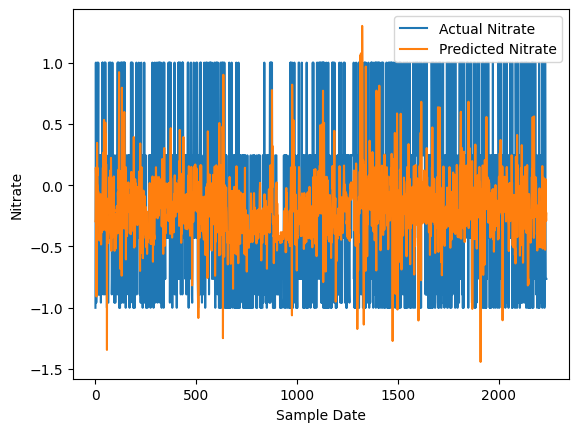

In [46]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Nitrate')
plt.plot(predicted, label='Predicted Nitrate')
plt.xlabel('Sample Date')
plt.ylabel('Nitrate')
plt.legend()
plt.show()

In [44]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([4.29853399, 4.39248795, 6.89971783, ..., 4.5181084 , 4.32313306,
       4.67756977])

In [45]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.1       ,  7.5       , 12.        , ...,  1.49999992,
        1.49999992,  1.49999992])

##### Adjusted to actual Nitrate conc training data LSTM plots

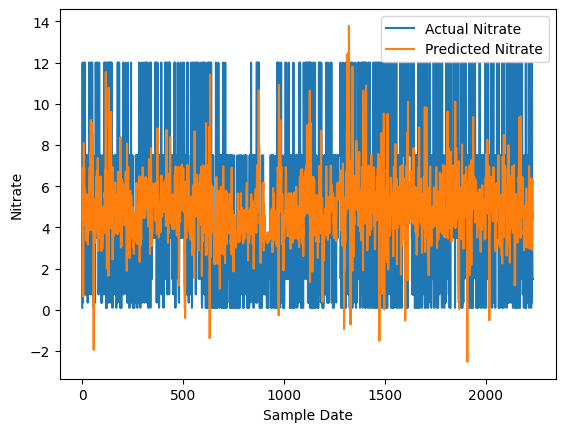

In [48]:
plt.plot(new_y_train, label='Actual Nitrate')
plt.plot(train_predictions, label='Predicted Nitrate')
plt.xlabel('Sample Date')
plt.ylabel('Nitrate')
plt.legend()
plt.show()

# Test data LSTM plots

In [49]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 5.53034058,  4.58361599,  3.50188865,  3.59010902,  3.68779069,
        3.69735092,  3.70934617,  3.70481164,  3.73772365,  3.8104782 ,
        4.83157373,  5.64474033,  5.05430238,  4.42339585,  3.77822122,
        4.87072807,  5.61878332,  5.96725459,  5.53518383,  4.33442469,
        5.90436741,  6.60142007,  4.97763944,  6.36830246,  6.41119133,
        5.2762625 ,  8.95806629,  4.60591587,  6.80629637,  7.55021766,
        3.27660016,  5.62160578,  6.45381811,  6.19833084,  4.86771463,
        5.11617279,  5.72516271,  2.60447444,  5.77006979,  5.09799107,
        5.03522234,  5.12437898,  4.25538224,  3.63699805,  5.68625344,
        5.14880498,  4.16991216,  4.88002959,  4.44544748,  4.05539396,
        4.85043726,  6.50198285,  5.34323274, -0.57796641,  5.59764419,
        5.58387464,  4.96048141,  4.31355864,  5.07472671,  5.65921315,
        5.87950581,  4.99960277,  4.28135947,  3.23260647,  4.28819424,
        2.97252208,  4.69797407,  4.81867307,  3.1957405 ,  4.09

In [50]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 3.49999997,  0.74999996,  3.49999997,  3.49999997,  3.49999997,
        3.49999997,  3.49999997,  3.49999997,  3.49999997,  7.5       ,
        7.5       ,  3.49999997,  1.49999992,  0.1       ,  7.5       ,
        7.5       ,  7.5       ,  0.1       ,  0.34999999, 12.        ,
        0.1       ,  0.1       , 12.        ,  7.5       ,  3.49999997,
        0.1       ,  0.1       ,  7.5       ,  0.1       ,  0.1       ,
       12.        ,  7.5       ,  7.5       ,  3.49999997,  7.5       ,
        7.5       ,  7.5       ,  7.5       ,  3.49999997,  7.5       ,
        3.49999997,  1.49999992,  1.49999992, 12.        ,  1.49999992,
        0.74999996,  7.5       ,  3.49999997,  0.74999996,  7.5       ,
       12.        ,  3.49999997,  0.34999999,  7.5       ,  7.5       ,
        0.1       ,  3.49999997,  7.5       ,  7.5       ,  7.5       ,
        0.34999999,  3.49999997,  0.1       ,  7.5       ,  0.34999999,
        1.49999992,  7.5       ,  0.1       ,  1.49999992, 12.  

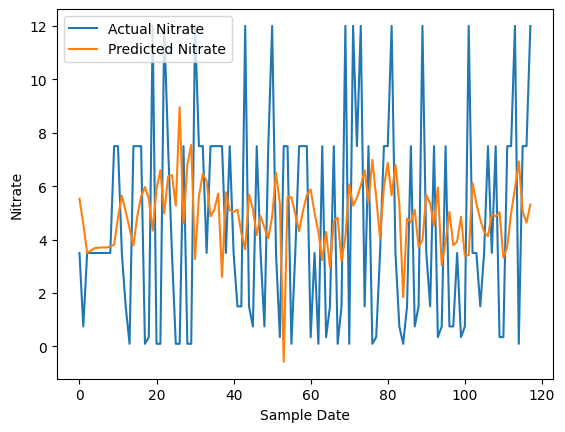

In [51]:
plt.plot(new_y_test, label='Actual Nitrate')
plt.plot(test_predictions, label='Predicted Nitrate')
plt.xlabel('Sample Date')
plt.ylabel('Nitrate')
plt.legend()
plt.show()
